In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [7]:
# Folder where the experiment folders are located
data_folder = r'/Volumes/Seagate Basic/20230705_NaumannLab_DOI_Experiments'

## Process and combine the individual datasets

In [8]:
b_dfs = []  # list of baseline dataframes
d_dfs = []  # list of drugtreated dataframes

cols = ['distance_traveled', 'speed'] * 24
cols = ['time'] + cols

with os.scandir(data_folder) as entries:
    for entry in entries:
        if os.path.isdir(entry.path) and entry.name.startswith('EK'):
            b_csv_path = os.path.join(entry.path, 'baseline', 'Updated_Trimmed_Tracking', 'results', 'distance_traveled_metrics.csv')
            b_df = pd.read_csv(b_csv_path, header=9).set_axis(cols, axis='columns')
            b_dfs.append(b_df)

            d_csv_path = os.path.join(entry.path, 'drugtreated', 'results', 'distance_traveled_metrics.csv')
            d_df = pd.read_csv(d_csv_path, header=9).set_axis(cols, axis='columns')
            d_dfs.append(d_df)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Seagate Basic/20230705_NaumannLab_DOI_Experiments/EK_8dpf_DOI_doseresponse_20230705/baseline/Updated_Trimmed_Tracking/results/distance_traveled_metrics.csv'

In [294]:
# Split eggwater vs doi baseline

eggwater_b_dfs = []
doi_b_dfs = []

for i, df in enumerate(b_dfs):
    if i == 0:
        # First dataframe will also include the time column
        dist_df = df[['time', 'distance_traveled']]
        eggwater_b_dfs.append(dist_df.iloc[:, :13])
        doi_b_dfs.append(dist_df.iloc[:, np.r_[0, 13:25]])
        
    else:
        dist_df = df['distance_traveled']
        eggwater_b_dfs.append(dist_df.iloc[:, :12])
        doi_b_dfs.append(dist_df.iloc[:, 12:])

In [295]:
# Split eggwater vs doi drugtreated

eggwater_d_dfs = []
doi_d_dfs = []

for i, df in enumerate(d_dfs):
    if i == 0:
        # First dataframe will also include the time column
        dist_df = df[['time', 'distance_traveled']]
        eggwater_d_dfs.append(dist_df.iloc[:, :13])
        doi_d_dfs.append(dist_df.iloc[:, np.r_[0, 13:25]])
        
    else:
        dist_df = df['distance_traveled']
        eggwater_d_dfs.append(dist_df.iloc[:, :12])
        doi_d_dfs.append(dist_df.iloc[:, 12:])

In [296]:
# Concatenate dataframes from different experiment sessions into one 

eggwater_b_df = pd.concat(eggwater_b_dfs, axis=1)
doi_b_df = pd.concat(doi_b_dfs, axis=1)

eggwater_d_df = pd.concat(eggwater_d_dfs, axis=1)
doi_d_df = pd.concat(doi_d_dfs, axis=1)

In [297]:
# Add an 'average_dist' column that has the average distance traveled across fish

eggwater_b_df['average_dist'] = eggwater_b_df.iloc[:, 1:].mean(axis=1)
doi_b_df['average_dist'] = doi_b_df.iloc[:, 1:].mean(axis=1)
eggwater_d_df['average_dist'] = eggwater_d_df.iloc[:, 1:].mean(axis=1)
doi_d_df['average_dist'] = doi_d_df.iloc[:, 1:].mean(axis=1)

### Edit stimuli

In [369]:
# Load one of the stimulus metadata csv files

stim_path = r'/Users/minelarinel/Documents/Duke University/Naumann Lab/DOI/Behavior/DOI_Experiments_MCAM/EK_7dpf_CD_DOI_50ugml_20230404/drugtreated/results/stimulus_metadata.csv'

stim_df = pd.read_csv(stim_path, header=6)
stim_df

time flash_color  flash_lux flash_illumination_device  \
0         0.00000       white     5000.0              transmission   
1         0.03333       white     5000.0              transmission   
2         0.06666       white     5000.0              transmission   
3         0.09999       white     5000.0              transmission   
4         0.13332       white     5000.0              transmission   
...           ...         ...        ...                       ...   
63295  2109.62235         NaN        NaN                       NaN   
63296  2109.65568         NaN        NaN                       NaN   
63297  2109.68901         NaN        NaN                       NaN   
63298  2109.72234         NaN        NaN                       NaN   
63299  2109.75567         NaN        NaN                       NaN   

       vibration_frequency  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
...                    ...  
63295                  NaN  
63296                  NaN  
63297                  NaN  
63298                  NaN  
63299                  NaN  

[63300 rows x 5 columns]

In [390]:
# Label the different stimuli

stim_df['stim_name'] = ''

for i, row in stim_df.iterrows():
    if row['time'] <= 300.0:
        stim_df.loc[i, 'stim_name'] = 'locomotor'
        
    elif row['vibration_frequency'] == 300:
        stim_df.loc[i, 'stim_name'] = 'vibration_startle'
        
    elif row['flash_lux'] == 10000:
        stim_df.loc[i, 'stim_name'] = 'light_flash'
        
    elif row['flash_lux'] == 5000:
        stim_df.loc[i, 'stim_name'] = 'light_epoch'
        
    else:
        stim_df.loc[i, 'stim_name'] = 'dark_epoch'
        
stim_df.to_csv(os.path.join(data_folder, 'stim_df.csv'))

In [401]:
# Distinguish dark flash from dark epoch

stim_df = pd.read_csv(os.path.join(data_folder, 'stim_df.csv'), index_col=0)

row_inds = stim_df[stim_df.stim_name == 'dark_epoch'].index.values  # row indices of dark stimuli
diffs = np.diff(row_inds)

begin = False
start = 0
stop = 0

for i, diff in enumerate(diffs):
    if diff == 1 and begin is False:
        # if it's the beginning of a new dark stimulus
        begin = True
        start = row_inds[i]
    
    elif diff == 1 and begin is True:
        # if the dark stimulus has already begun
        continue
    
    elif diff != 1:
        # if the dark stimulus ends
        begin = False
        stop = row_inds[i]
        
        if stim_df.loc[stop, 'time'] - stim_df.loc[start, 'time'] <= 1.05:
            stim_df.loc[start:stop, 'stim_name'] = 'dark_flash'
            
stim_df.to_csv(os.path.join(data_folder, 'stim_df.csv'))

In [404]:
# Add stimulus numbers

stim_df = pd.read_csv(os.path.join(data_folder, 'stim_df.csv'), index_col=0)

stim_df['stim_num'] = 0

for stim in stim_df.stim_name.unique():
    stim_num = 0
    sub_df = stim_df[stim_df.stim_name == stim]

    prev_i = -1
    for i, row in sub_df.iterrows():

        if prev_i == -1:  # for the first row of sub_df
            stim_df.loc[i, 'stim_num'] = stim_num
            prev_i = i

        elif i-1 == prev_i:
            stim_df.loc[i, 'stim_num'] = stim_num
            prev_i = i

        else:
            stim_num += 1
            stim_df.loc[i, 'stim_num'] = stim_num
            prev_i = i

stim_df.to_csv(os.path.join(data_folder, 'stim_df.csv'))

In [406]:
# Add stimuli to main dataframes and save as csv

stim_df = pd.read_csv(os.path.join(data_folder, 'stim_df.csv'), index_col=0)

dfs = {'eggwater_baseline': eggwater_b_df, 
       'doi_baseline': doi_b_df, 
       'eggwater_drugtreated': eggwater_d_df, 
       'doi_drugtreated': doi_d_df}

for i, name in enumerate(dfs):
    df = pd.concat([dfs[name], stim_df], axis=1)
    df.to_csv(os.path.join(data_folder, f'{name}.csv'))

In [3]:
eggwater_baseline = pd.read_csv(os.path.join(data_folder, 'eggwater_baseline.csv'), index_col=0)
doi_baseline = pd.read_csv(os.path.join(data_folder, 'doi_baseline.csv'), index_col=0)
eggwater_drugtreated = pd.read_csv(os.path.join(data_folder, 'eggwater_drugtreated.csv'), index_col=0)
doi_drugtreated = pd.read_csv(os.path.join(data_folder, 'doi_drugtreated.csv'), index_col=0)

dfs = [eggwater_baseline, doi_baseline, eggwater_drugtreated, doi_drugtreated]

<ipython-input-3-8c7fe72f7f1c>:1: DtypeWarning: Columns (76,78) have mixed types. Specify dtype option on import or set low_memory=False.
  eggwater_baseline = pd.read_csv(os.path.join(data_folder, 'eggwater_baseline.csv'), index_col=0)
<ipython-input-3-8c7fe72f7f1c>:2: DtypeWarning: Columns (76,78) have mixed types. Specify dtype option on import or set low_memory=False.
  doi_baseline = pd.read_csv(os.path.join(data_folder, 'doi_baseline.csv'), index_col=0)
<ipython-input-3-8c7fe72f7f1c>:3: DtypeWarning: Columns (76,78) have mixed types. Specify dtype option on import or set low_memory=False.
  eggwater_drugtreated = pd.read_csv(os.path.join(data_folder, 'eggwater_drugtreated.csv'), index_col=0)
<ipython-input-3-8c7fe72f7f1c>:4: DtypeWarning: Columns (76,78) have mixed types. Specify dtype option on import or set low_memory=False.
  doi_drugtreated = pd.read_csv(os.path.join(data_folder, 'doi_drugtreated.csv'), index_col=0)


## Whole experiment locomotion

In [410]:
# Adds a binned_time column which is the time that each row belongs to

time_bin = 1.0 # in seconds

for df in dfs:
    df['binned_time'] = 0

    for i, row in df.iterrows():
        if df.loc[i, 'time'] < time_bin:
            df.loc[i, 'binned_time'] = time_bin
        else:
            time_bin += 1
            df.loc[i, 'binned_time'] = time_bin
            
    time_bin = 1.0

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2034340183.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0, 0].plot(eggwater_baseline.groupby(['binned_time']).sum()['average_dist'])
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2034340183.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0, 1].plot(doi_baseline.groupby(['binned_time']).sum()['average_dist'])
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2034340183.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only

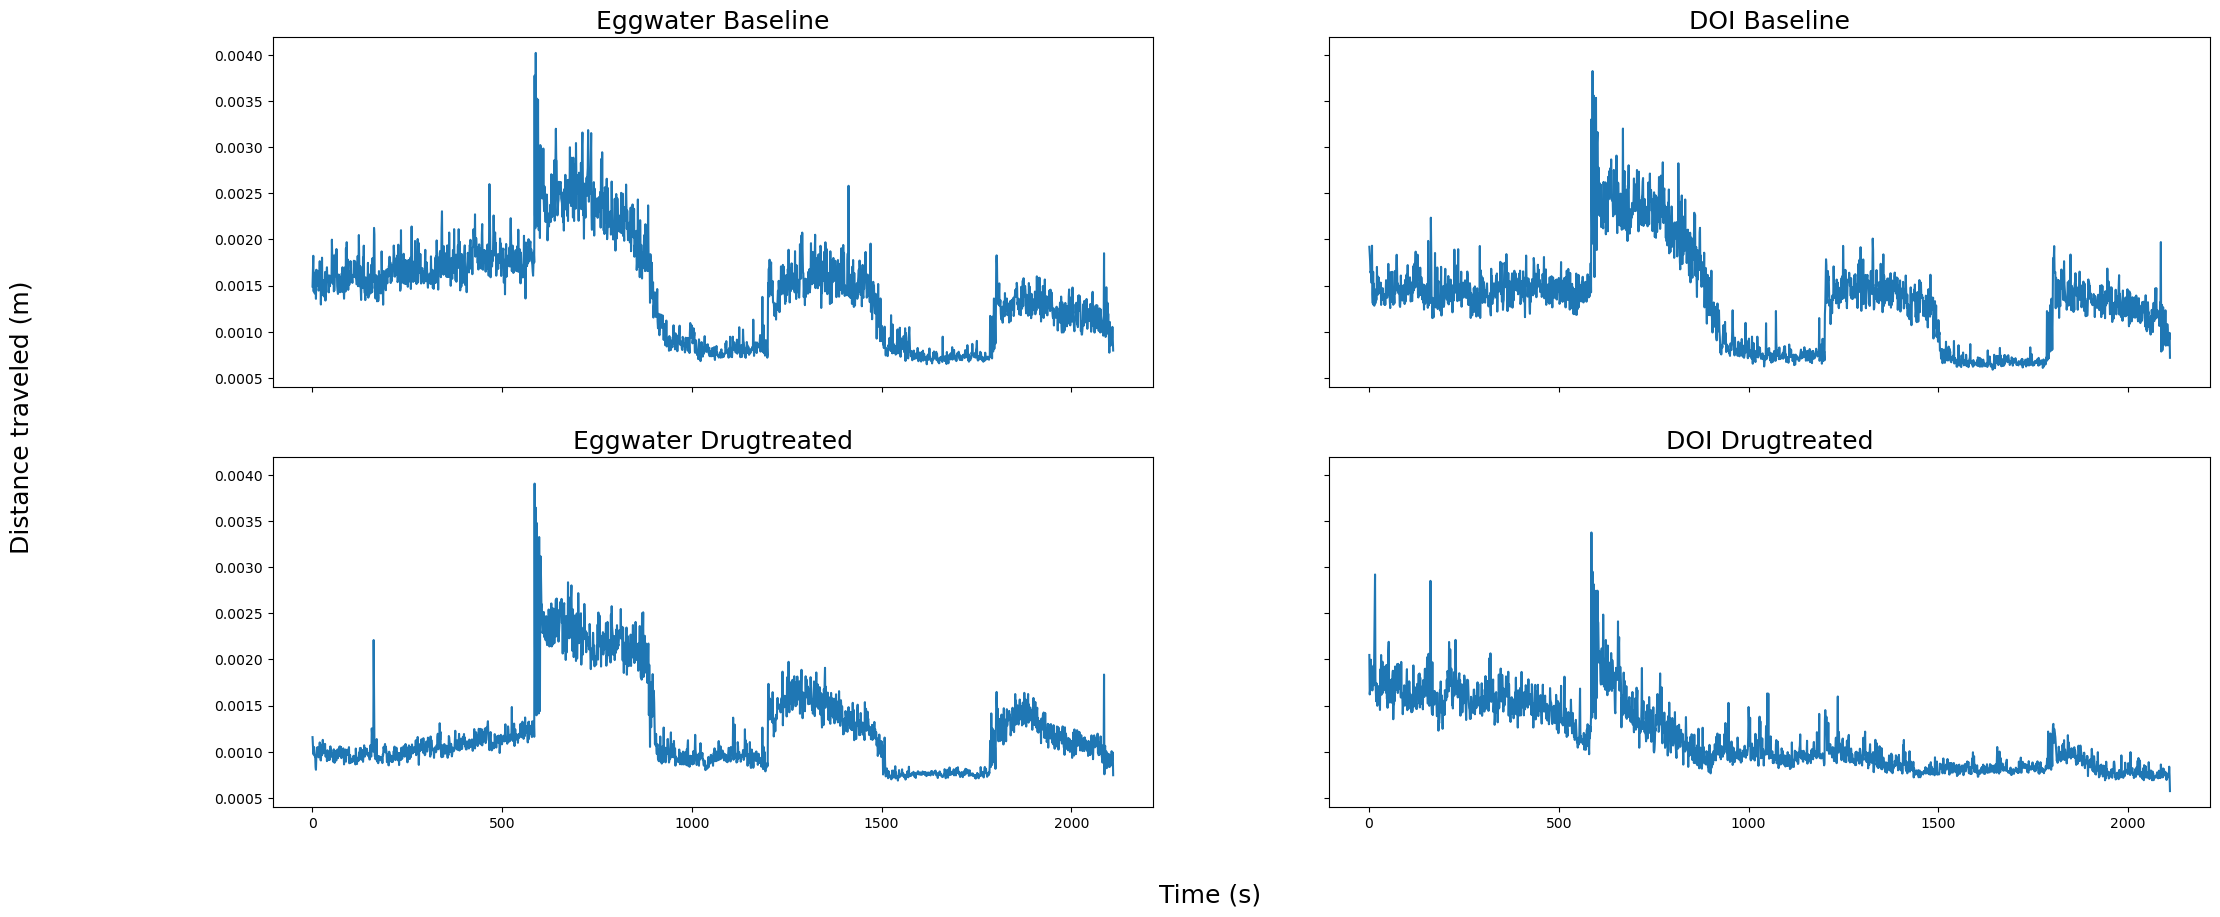

In [411]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey=True, sharex=True)

axs[0, 0].plot(eggwater_baseline.groupby(['binned_time']).sum()['average_dist'])
axs[0, 0].set_title('Eggwater Baseline', fontsize=18)

axs[0, 1].plot(doi_baseline.groupby(['binned_time']).sum()['average_dist'])
axs[0, 1].set_title('DOI Baseline', fontsize=18)

axs[1, 0].plot(eggwater_drugtreated.groupby(['binned_time']).sum()['average_dist'])
axs[1, 0].set_title('Eggwater Drugtreated', fontsize=18)

axs[1, 1].plot(doi_drugtreated.groupby(['binned_time']).sum()['average_dist'])
axs[1, 1].set_title('DOI Drugtreated', fontsize=18)

fig.supxlabel('Time (s)', fontsize=18)
fig.supylabel('Distance traveled (m)', fontsize=18)

plt.savefig(os.path.join(data_folder, f'distance_traveled_all_binned{time_bin}s.pdf'))

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2474210915.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(eggwater_baseline.groupby(['binned_time']).sum()['average_dist'], label='Egg water')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2474210915.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(doi_baseline.groupby(['binned_time']).sum()['average_dist'], label='DOI')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2474210915.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a fu

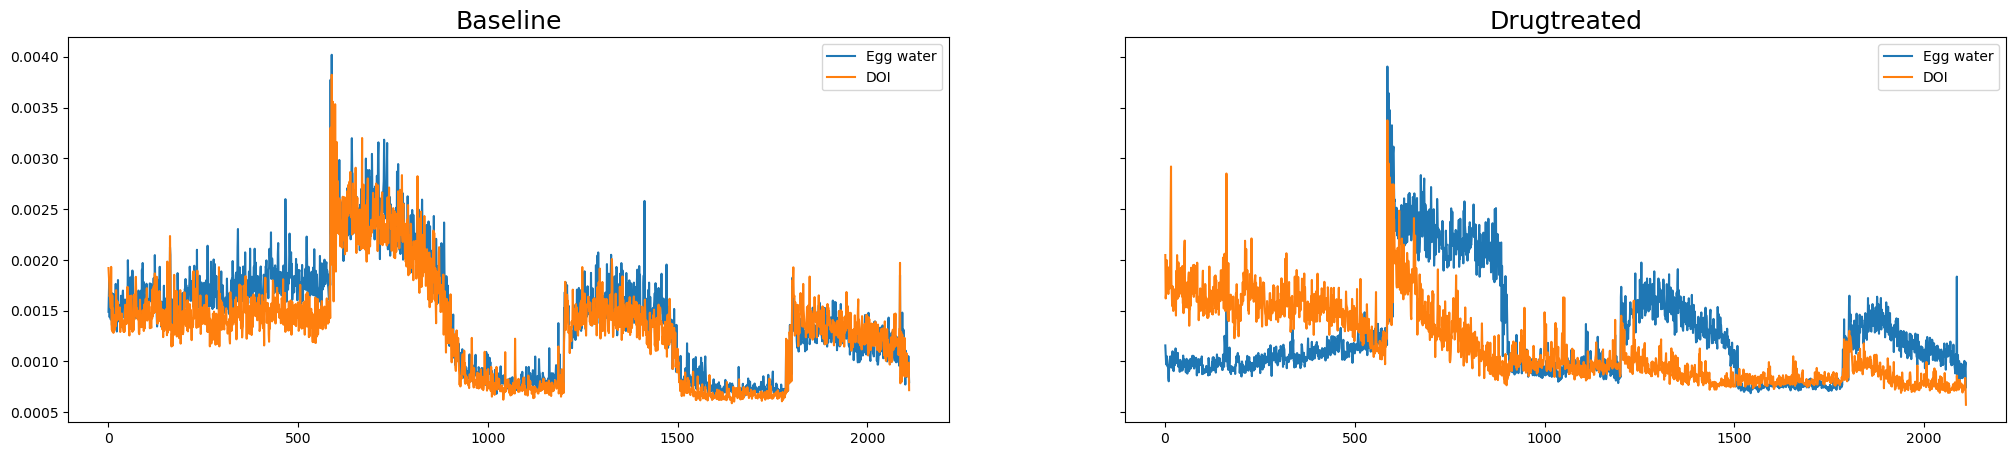

In [412]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

axs[0].plot(eggwater_baseline.groupby(['binned_time']).sum()['average_dist'], label='Egg water')
axs[0].plot(doi_baseline.groupby(['binned_time']).sum()['average_dist'], label='DOI')
axs[0].set_title('Baseline', fontsize=18)
axs[0].legend()

axs[1].plot(eggwater_drugtreated.groupby(['binned_time']).sum()['average_dist'], label='Egg water')
axs[1].plot(doi_drugtreated.groupby(['binned_time']).sum()['average_dist'], label='DOI')
axs[1].set_title('Drugtreated', fontsize=18)
axs[1].legend()

plt.savefig(os.path.join(data_folder, f'distance_traveled_bd_binned{time_bin}s.pdf'))

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/1206304007.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(eggwater_baseline.groupby(['binned_time']).sum()['average_dist'], label='Baseline')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/1206304007.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(eggwater_drugtreated.groupby(['binned_time']).sum()['average_dist'], label='Treated')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/1206304007.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecat

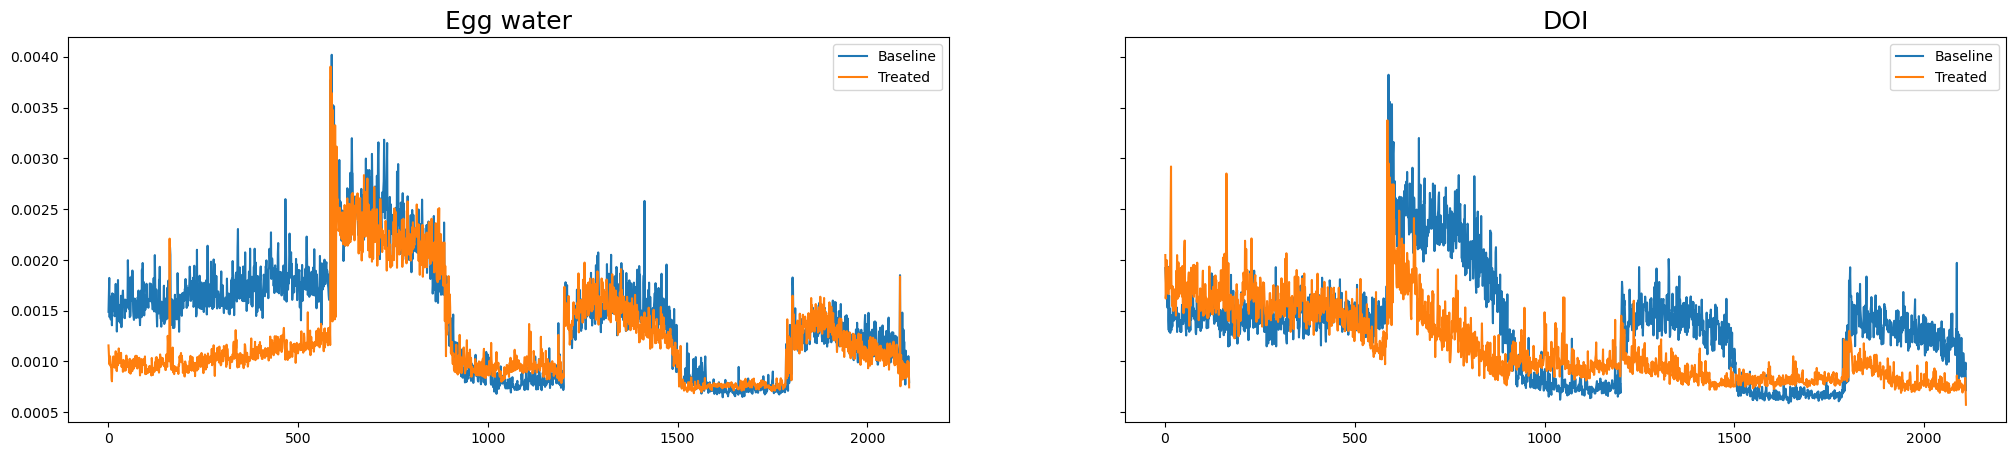

In [413]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

axs[0].plot(eggwater_baseline.groupby(['binned_time']).sum()['average_dist'], label='Baseline')
axs[0].plot(eggwater_drugtreated.groupby(['binned_time']).sum()['average_dist'], label='Treated')
axs[0].set_title('Egg water', fontsize=18)
axs[0].legend()

axs[1].plot(doi_baseline.groupby(['binned_time']).sum()['average_dist'], label='Baseline')
axs[1].plot(doi_drugtreated.groupby(['binned_time']).sum()['average_dist'], label='Treated')
axs[1].set_title('DOI', fontsize=18)
axs[1].legend()

plt.savefig(os.path.join(data_folder, f'distance_traveled_ed_binned{time_bin}s.pdf'))

### Dark flash #1

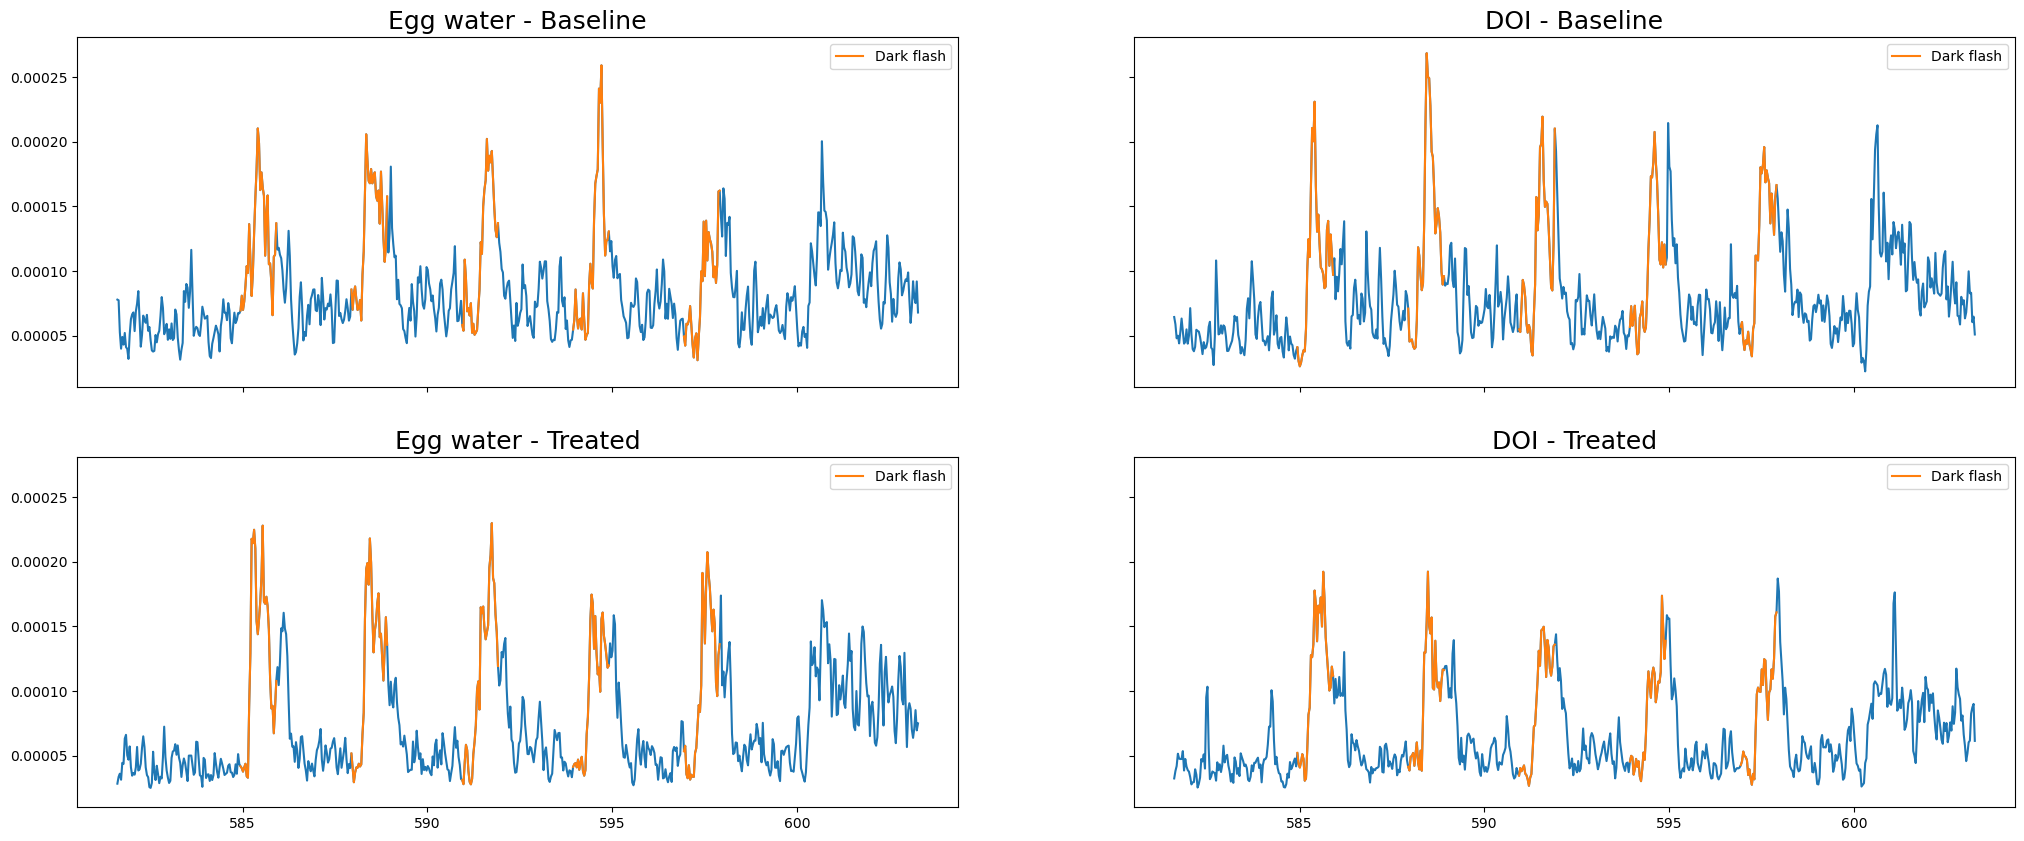

In [414]:
titles = ['Egg water - Baseline', 'DOI - Baseline', 'Egg water - Treated', 'DOI - Treated']
gap = 100

fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey=True, sharex=True)

for i, df in enumerate(dfs):
    dflash_start = df[df.stim_name == 'dark_flash'].index.values[0]
    depoch_start = df[df.stim_name == 'dark_epoch'].index.values[0]

    dflash_subdf = df.loc[dflash_start-gap:depoch_start+gap, :]
    
    y = dflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[dflash_subdf.stim_name != 'dark_flash'] = np.nan
    
    row = int(i/2)
    col = int(i%2)

    axs[row, col].plot(dflash_subdf.time, y)
    axs[row, col].plot(dflash_subdf.time, flash, label='Dark flash')
    axs[row, col].set_title(titles[i], fontsize=18)
    axs[row, col].legend()

plt.savefig(os.path.join(data_folder, f'darkflash_all.pdf'))

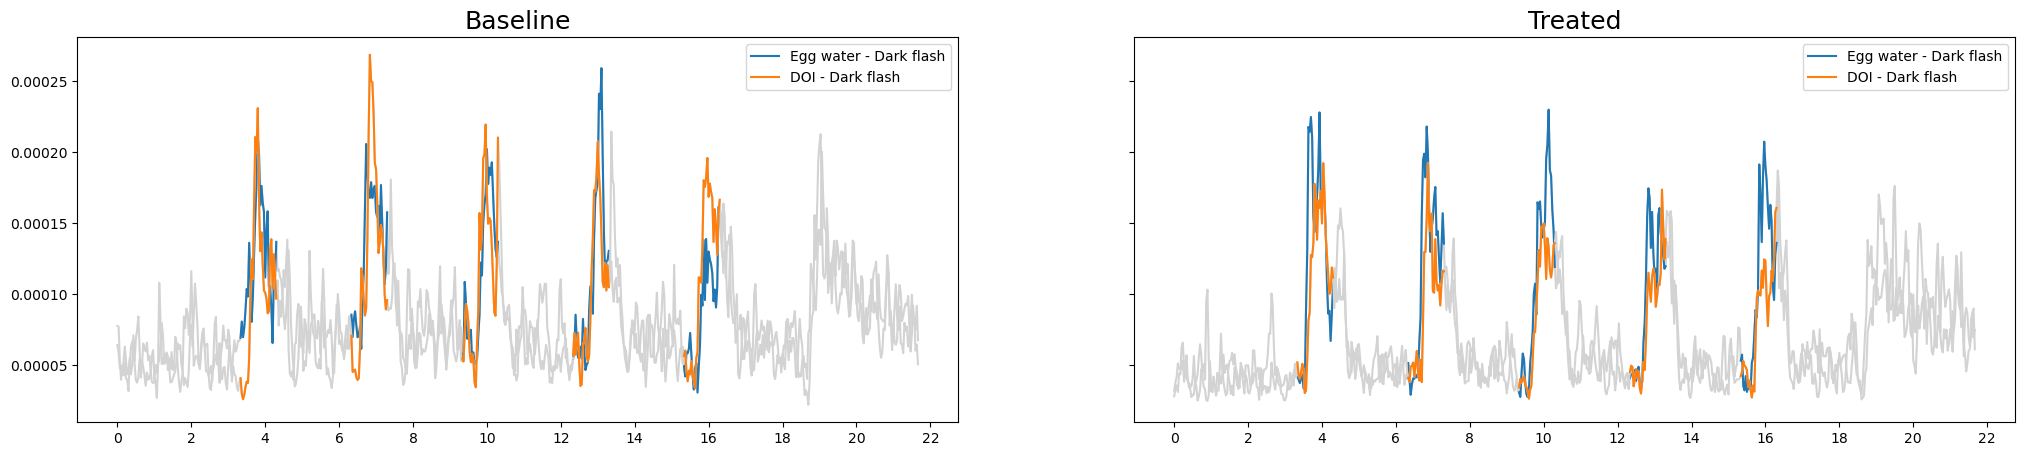

In [415]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    dflash_start = df[df.stim_name == 'dark_flash'].index.values[0]
    depoch_start = df[df.stim_name == 'dark_epoch'].index.values[0]

    dflash_subdf = df.loc[dflash_start-gap:depoch_start+gap, :]
    x = dflash_subdf.time - dflash_subdf.time.iloc[0]
    
    y = dflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[dflash_subdf.stim_name != 'dark_flash'] = np.nan
    
    col = int(i/2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Dark flash')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 2]:
        axs[col].set_title(titles[col], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'darkflash_bd.pdf'))

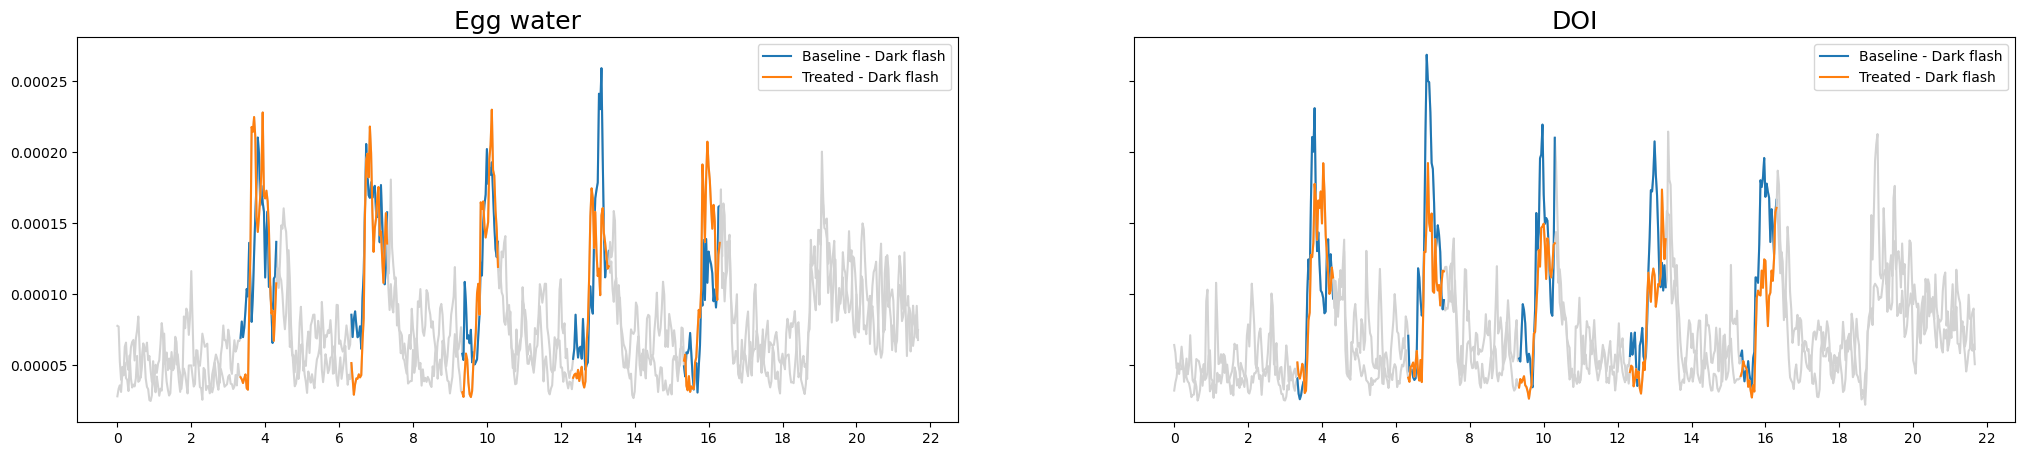

In [416]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    dflash_start = df[df.stim_name == 'dark_flash'].index.values[0]
    depoch_start = df[df.stim_name == 'dark_epoch'].index.values[0]

    dflash_subdf = df.loc[dflash_start-gap:depoch_start+gap, :]
    x = dflash_subdf.time - dflash_subdf.time.iloc[0]
    
    y = dflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[dflash_subdf.stim_name != 'dark_flash'] = np.nan
    
    col = int(i%2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Dark flash')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 1]:
        axs[col].set_title(titles[i], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'darkflash_ed.pdf'))

### Dark flash #2

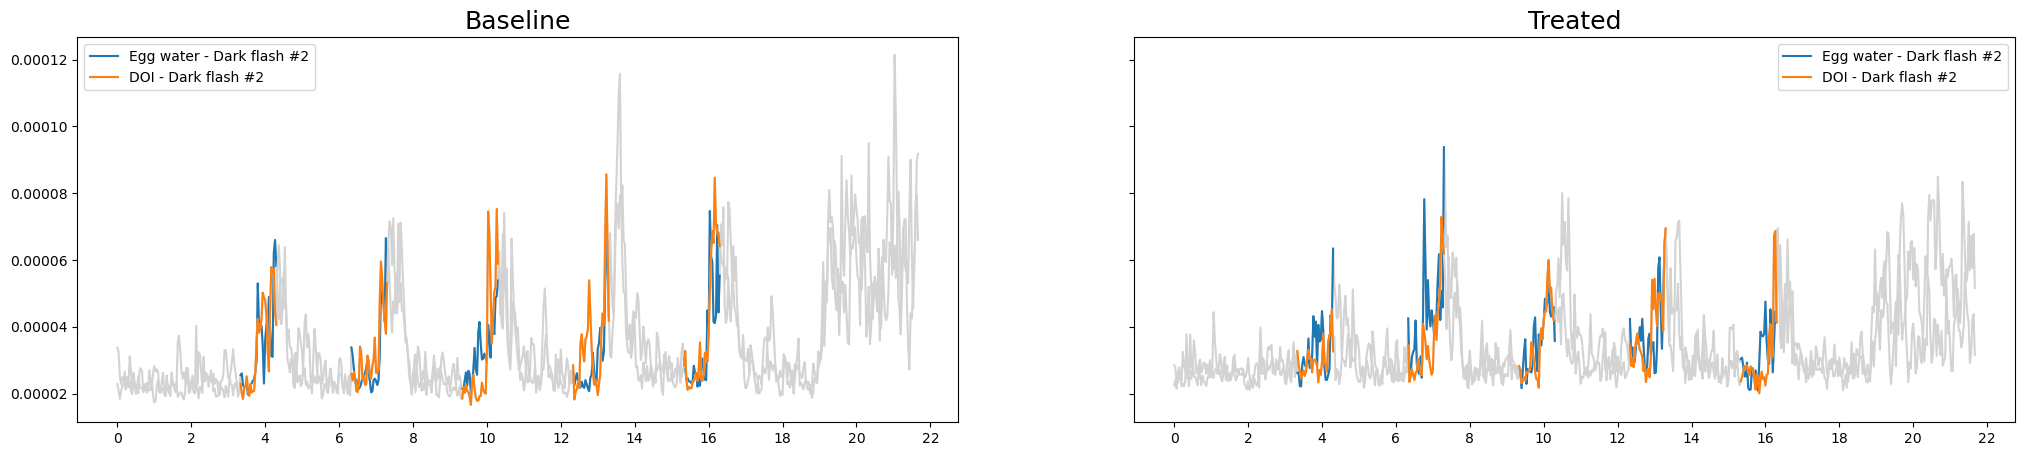

In [417]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    dflash_start = df[(df.stim_name == 'dark_flash') & (df.stim_num >= 5)].index.values[0]
    depoch_start = df[(df.stim_name == 'dark_epoch') & (df.stim_num == 12)].index.values[0]

    dflash_subdf = df.loc[dflash_start-gap:depoch_start+gap, :]
    x = dflash_subdf.time - dflash_subdf.time.iloc[0]
    
    y = dflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[dflash_subdf.stim_name != 'dark_flash'] = np.nan
    
    col = int(i/2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Dark flash #2')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 2]:
        axs[col].set_title(titles[col], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'darkflash2_bd.pdf'))

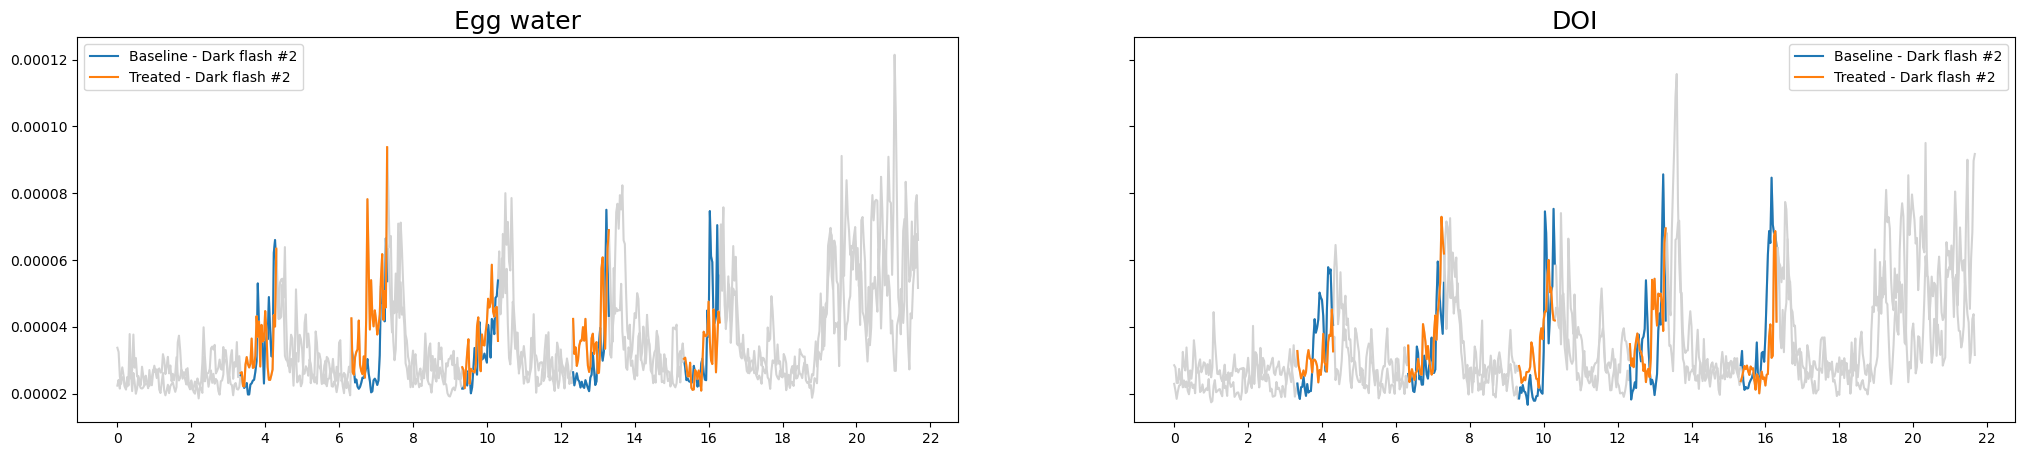

In [418]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    dflash_start = df[(df.stim_name == 'dark_flash') & (df.stim_num >= 5)].index.values[0]
    depoch_start = df[(df.stim_name == 'dark_epoch') & (df.stim_num == 12)].index.values[0]

    dflash_subdf = df.loc[dflash_start-gap:depoch_start+gap, :]
    x = dflash_subdf.time - dflash_subdf.time.iloc[0]
    
    y = dflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[dflash_subdf.stim_name != 'dark_flash'] = np.nan
    
    col = int(i%2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Dark flash #2')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 1]:
        axs[col].set_title(titles[i], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'darkflash2_ed.pdf'))

### Light flash #1

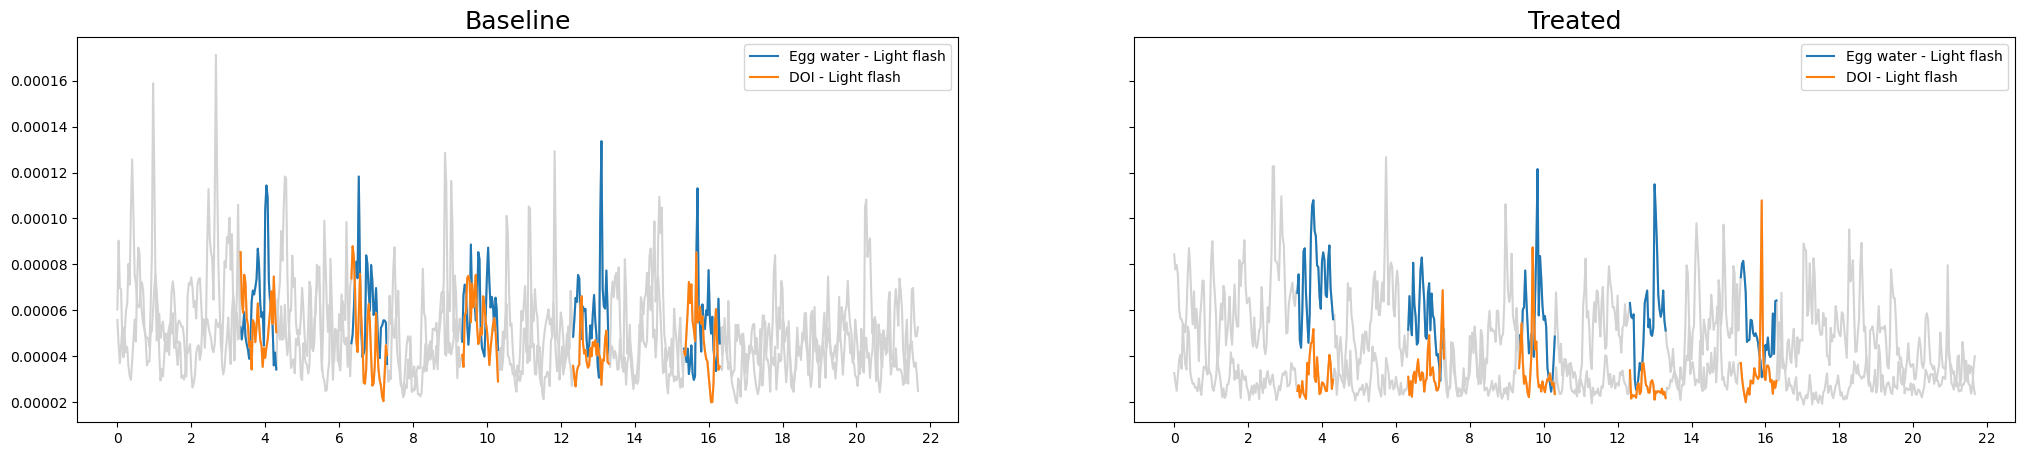

In [424]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    lflash_start = df[df.stim_name == 'light_flash'].index.values[0]
    lepoch_start = df[(df.stim_name == 'light_epoch') & (df.stim_num == 6)].index.values[0]

    lflash_subdf = df.loc[lflash_start-gap:lepoch_start+gap, :]
    x = lflash_subdf.time - lflash_subdf.time.iloc[0]
    
    y = lflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[lflash_subdf.stim_name != 'light_flash'] = np.nan
    
    col = int(i/2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Light flash')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 2]:
        axs[col].set_title(titles[col], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'lightflash_bd.pdf'))

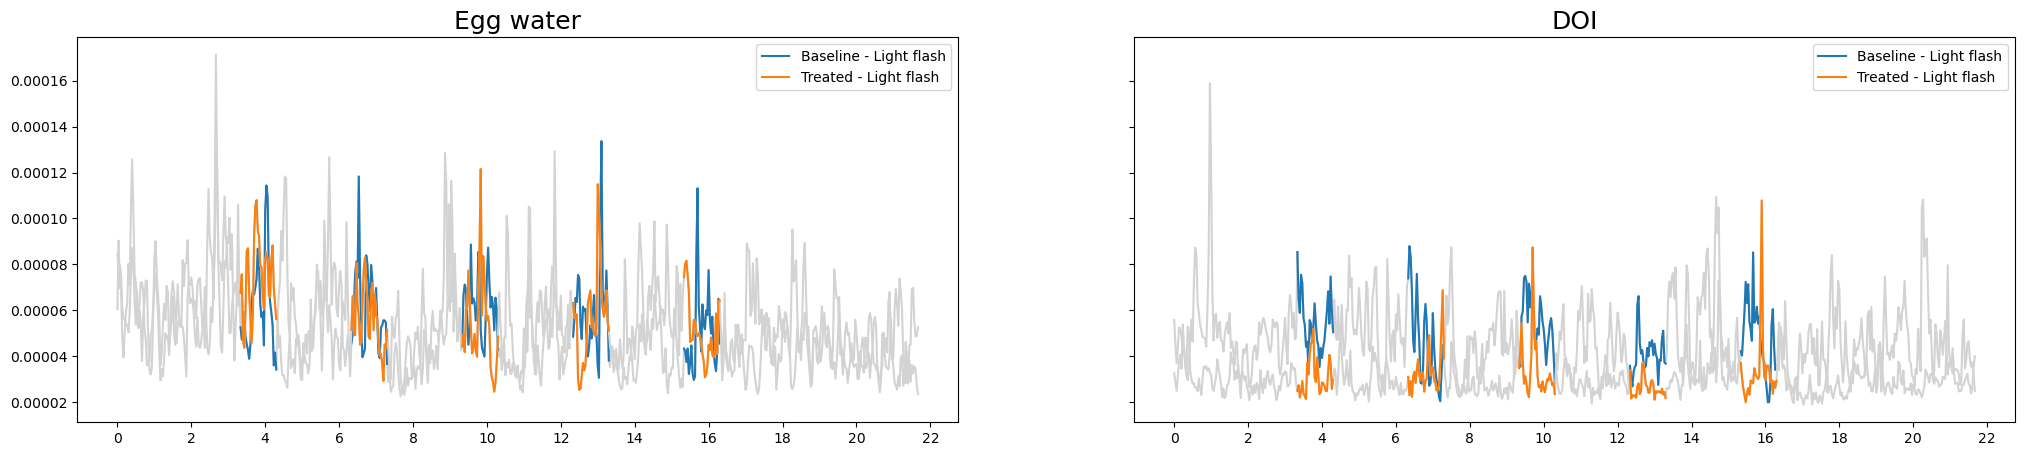

In [425]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    lflash_start = df[df.stim_name == 'light_flash'].index.values[0]
    lepoch_start = df[(df.stim_name == 'light_epoch') & (df.stim_num == 6)].index.values[0]

    lflash_subdf = df.loc[lflash_start-gap:lepoch_start+gap, :]
    x = lflash_subdf.time - lflash_subdf.time.iloc[0]
    
    y = lflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[lflash_subdf.stim_name != 'light_flash'] = np.nan
    
    col = int(i%2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Light flash')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 1]:
        axs[col].set_title(titles[i], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'lightflash_ed.pdf'))

### Light flash #2

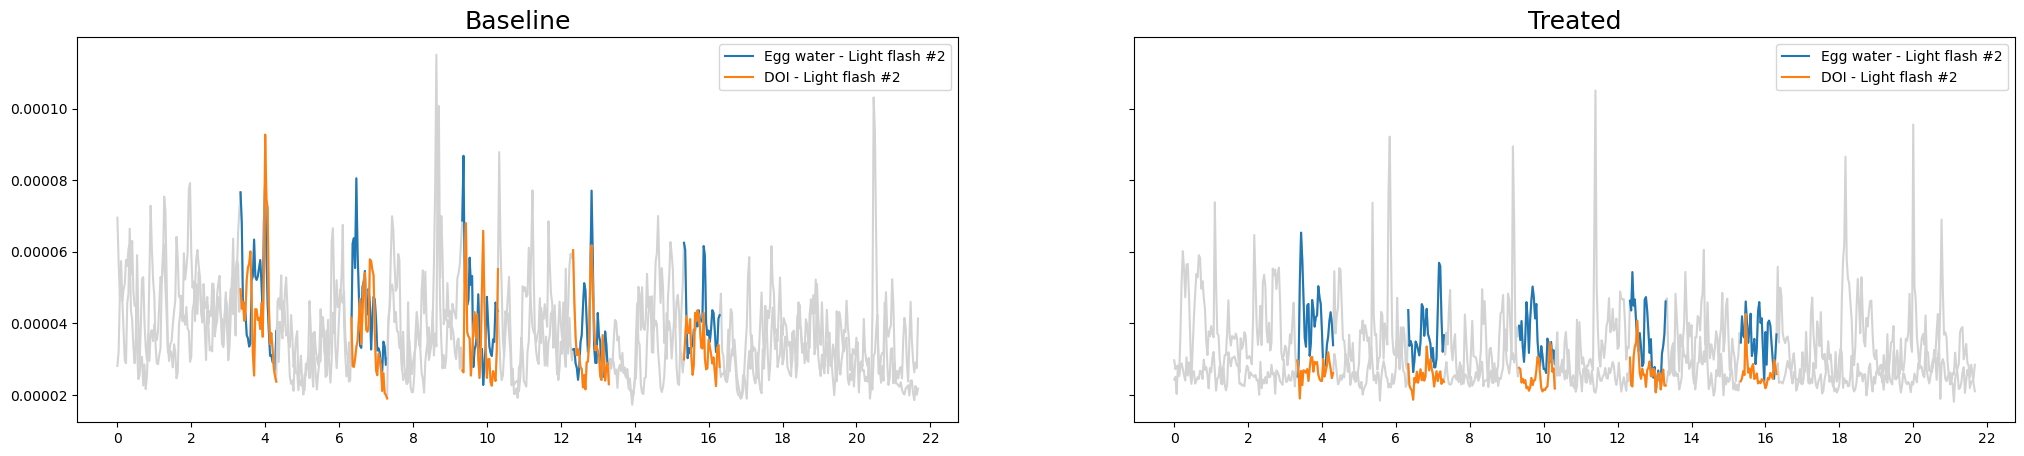

In [428]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    lflash_start = df[(df.stim_name == 'light_flash') & (df.stim_num >= 5)].index.values[0]
    lepoch_start = df[(df.stim_name == 'light_epoch') & (df.stim_num == 12)].index.values[0]

    lflash_subdf = df.loc[lflash_start-gap:lepoch_start+gap, :]
    x = lflash_subdf.time - lflash_subdf.time.iloc[0]
    
    y = lflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[lflash_subdf.stim_name != 'light_flash'] = np.nan
    
    col = int(i/2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Light flash #2')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 2]:
        axs[col].set_title(titles[col], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'lightflash2_bd.pdf'))

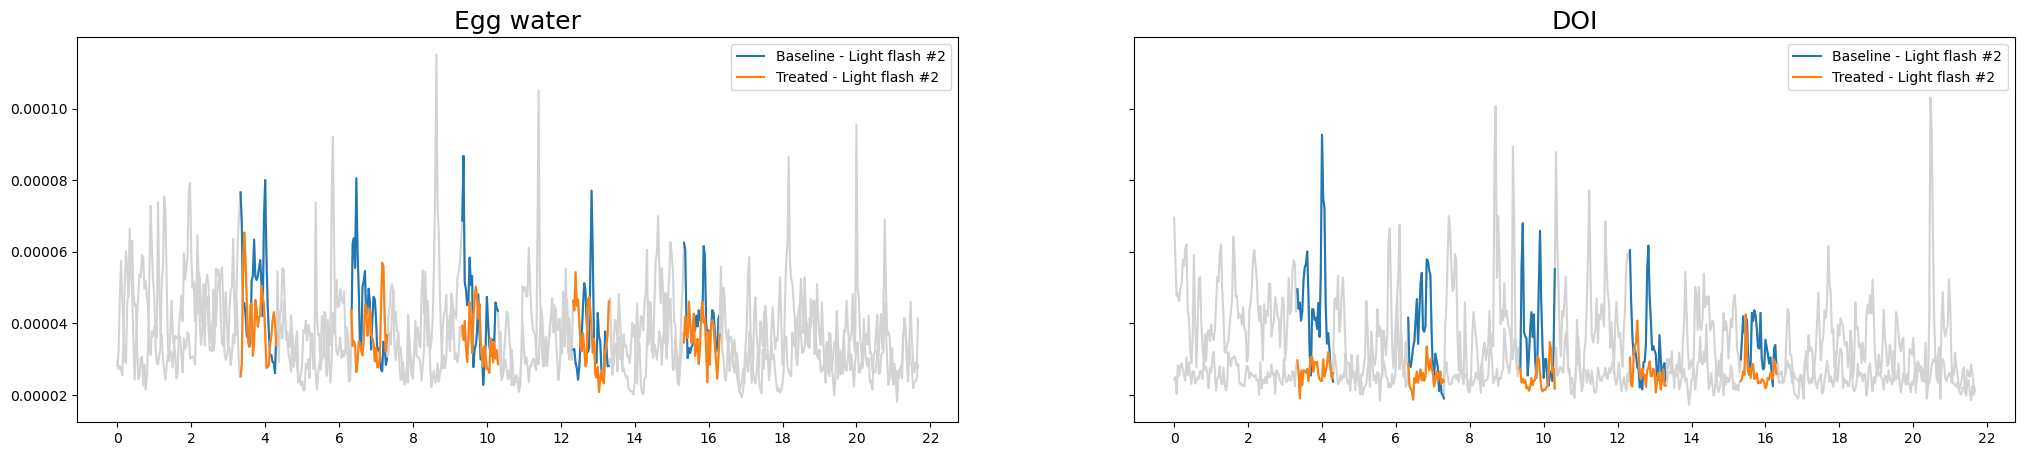

In [429]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    lflash_start = df[(df.stim_name == 'light_flash') & (df.stim_num >= 5)].index.values[0]
    lepoch_start = df[(df.stim_name == 'light_epoch') & (df.stim_num == 12)].index.values[0]

    lflash_subdf = df.loc[lflash_start-gap:lepoch_start+gap, :]
    x = lflash_subdf.time - lflash_subdf.time.iloc[0]
    
    y = lflash_subdf.average_dist.copy()
    flash = y.copy()
    flash[lflash_subdf.stim_name != 'light_flash'] = np.nan
    
    col = int(i%2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, flash, label=f'{labels[i]} - Light flash #2')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 1]:
        axs[col].set_title(titles[i], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'lightflash2_ed.pdf'))

### Vibration startle - light

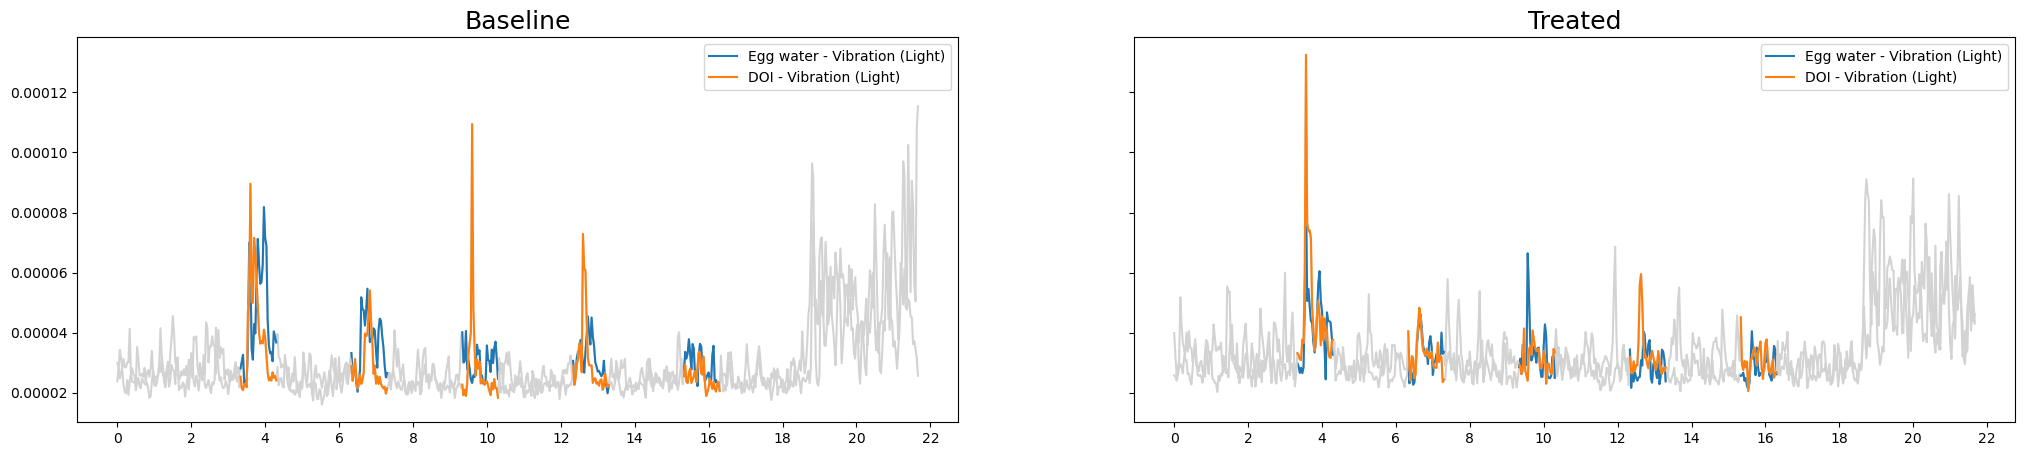

In [432]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    lvibration_start = df[df.stim_name == 'vibration_startle'].index.values[0]
    depoch_start = df[(df.stim_name == 'dark_epoch') & (df.stim_num == 6)].index.values[0]

    lvibration_subdf = df.loc[lvibration_start-gap:depoch_start+gap, :]
    x = lvibration_subdf.time - lvibration_subdf.time.iloc[0]
    
    y = lvibration_subdf.average_dist.copy()
    vibration = y.copy()
    vibration[lvibration_subdf.stim_name != 'vibration_startle'] = np.nan
    
    col = int(i/2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, vibration, label=f'{labels[i]} - Vibration (Light)')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 2]:
        axs[col].set_title(titles[col], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'vibrationlight_bd.pdf'))

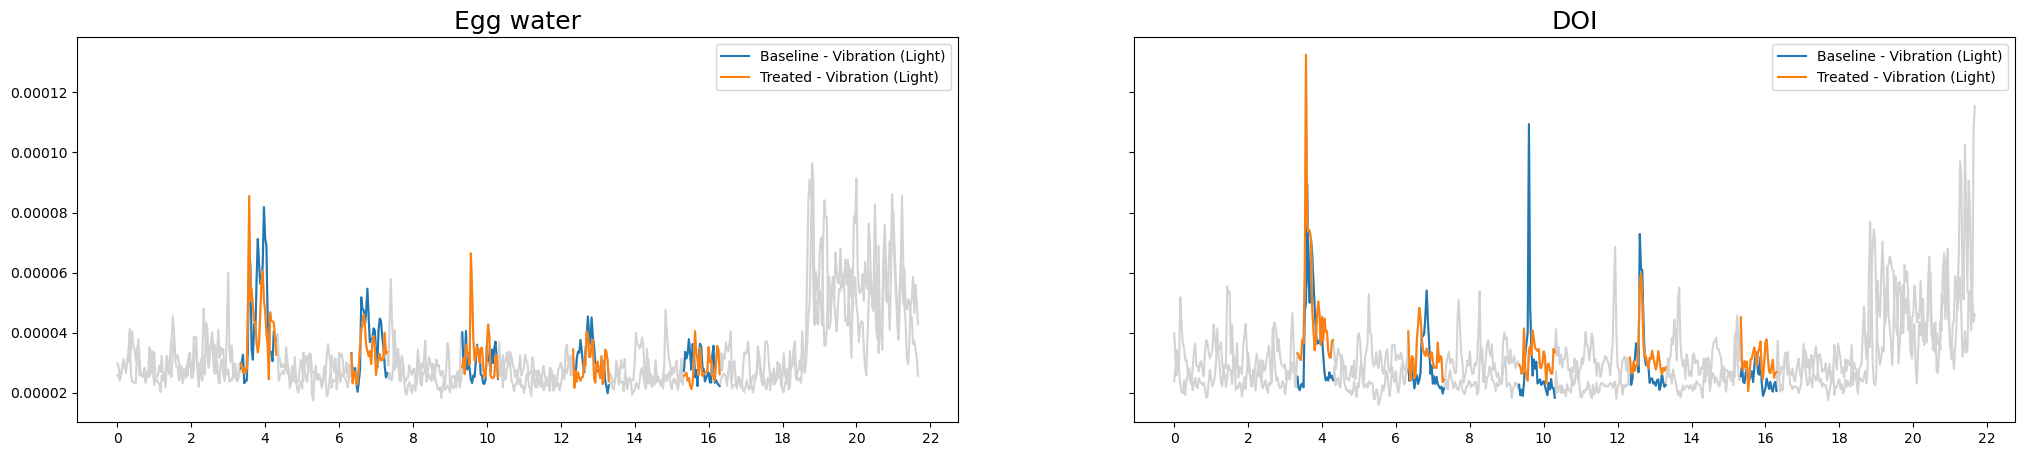

In [433]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    lvibration_start = df[df.stim_name == 'vibration_startle'].index.values[0]
    depoch_start = df[(df.stim_name == 'dark_epoch') & (df.stim_num == 6)].index.values[0]

    lvibration_subdf = df.loc[lvibration_start-gap:depoch_start+gap, :]
    x = lvibration_subdf.time - lvibration_subdf.time.iloc[0]
    
    y = lvibration_subdf.average_dist.copy()
    vibration = y.copy()
    vibration[lvibration_subdf.stim_name != 'vibration_startle'] = np.nan
    
    col = int(i%2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, vibration, label=f'{labels[i]} - Vibration (Light)')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 1]:
        axs[col].set_title(titles[i], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'vibrationlight_ed.pdf'))

### Vibration startle - dark

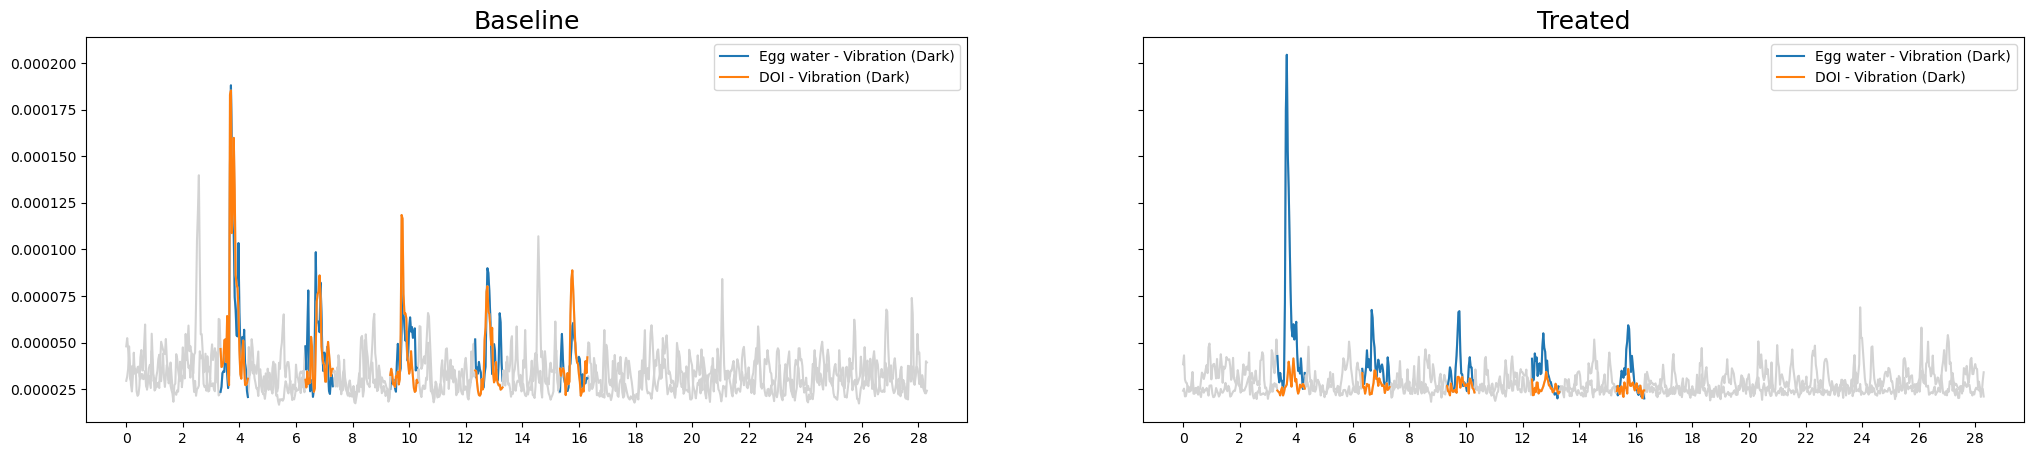

In [435]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    dvibration_start = df[(df.stim_name == 'vibration_startle') & (df.flash_color != 'white')].index.values[0]

    dvibration_subdf = df.loc[dvibration_start-gap:, :]
    x = dvibration_subdf.time - dvibration_subdf.time.iloc[0]
    
    y = dvibration_subdf.average_dist.copy()
    vibration = y.copy()
    vibration[dvibration_subdf.stim_name != 'vibration_startle'] = np.nan
    
    col = int(i/2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, vibration, label=f'{labels[i]} - Vibration (Dark)')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 2]:
        axs[col].set_title(titles[col], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'vibrationdark_bd.pdf'))

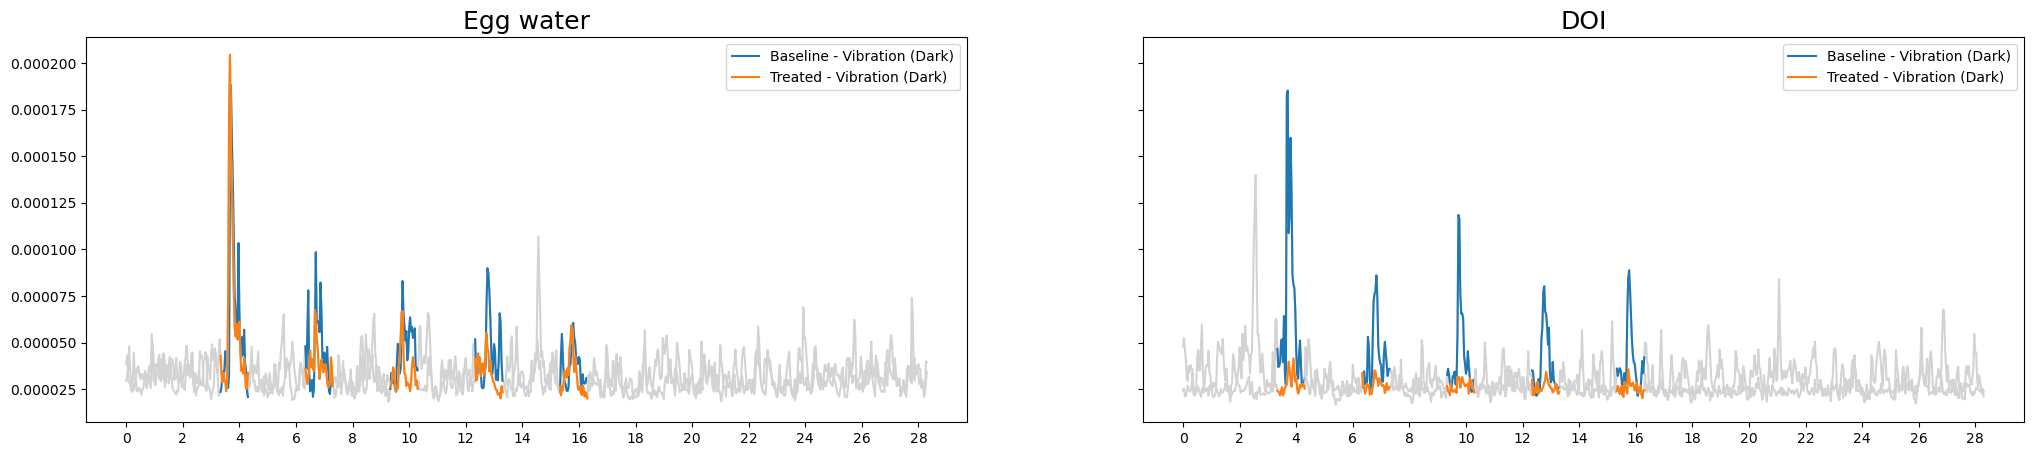

In [436]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    dvibration_start = df[(df.stim_name == 'vibration_startle') & (df.flash_color != 'white')].index.values[0]

    dvibration_subdf = df.loc[dvibration_start-gap:, :]
    x = dvibration_subdf.time - dvibration_subdf.time.iloc[0]
    
    y = dvibration_subdf.average_dist.copy()
    vibration = y.copy()
    vibration[dvibration_subdf.stim_name != 'vibration_startle'] = np.nan
    
    col = int(i%2)

    axs[col].plot(x, y, color='lightgray')
    axs[col].plot(x, vibration, label=f'{labels[i]} - Vibration (Dark)')
    axs[col].set_xticks(np.arange(min(x), max(x)+1, 2.0))
    axs[col].legend()
    
    if i in [0, 1]:
        axs[col].set_title(titles[i], fontsize=18)
    
plt.savefig(os.path.join(data_folder, f'vibrationdark_ed.pdf'))

## Peak startle response of average_dist

### Dark flash

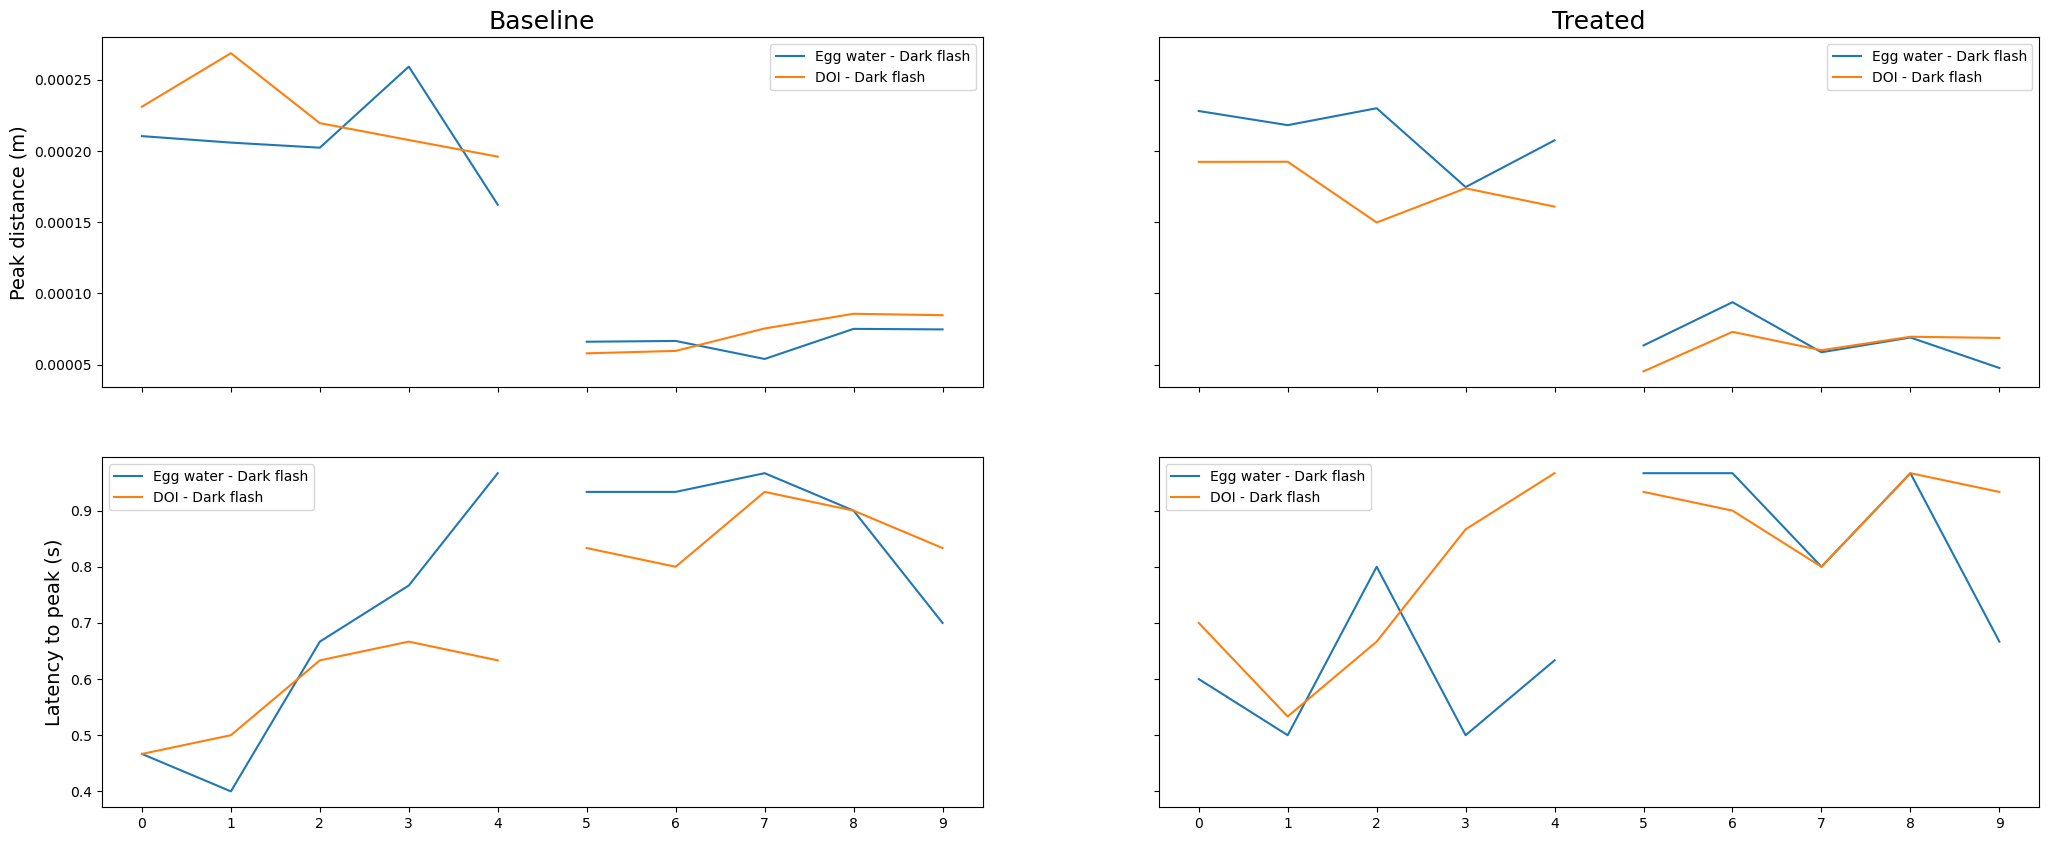

In [475]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row', sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    stim_nums = df[df.stim_name == 'dark_flash'].stim_num.unique()
    
    x = []
    peaks = []
    latencies = []
    
    for num in stim_nums:
        if num == 5:
            peaks.append(np.nan)
            latencies.append(np.nan)
            x.append(np.nan)
            
        trial = df[(df.stim_name == 'dark_flash') & (df.stim_num == num)]
        peak_dist = trial.average_dist.max()
        peak_index = trial.average_dist.idxmax()
        latency = trial.loc[peak_index, 'time'] - trial.iloc[0, 0]
        
        peaks.append(peak_dist)
        latencies.append(latency)
        x.append(num)
    
    col = int(i/2)
    
    axs[0, col].plot(x, peaks, label=f'{labels[i]} - Dark flash')
    axs[0, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[0, col].legend()
    
    axs[1, col].plot(x, latencies, label=f'{labels[i]} - Dark flash')
    axs[1, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[1, col].legend()

    if i in [0, 2]:
        axs[0, col].set_title(titles[col], fontsize=18)
        
    
axs[0, 0].set_ylabel('Peak distance (m)', fontsize=14)
axs[1, 0].set_ylabel('Latency to peak (s)', fontsize=14)
plt.savefig(os.path.join(data_folder, f'darkflash_adaptation_bd.pdf'))

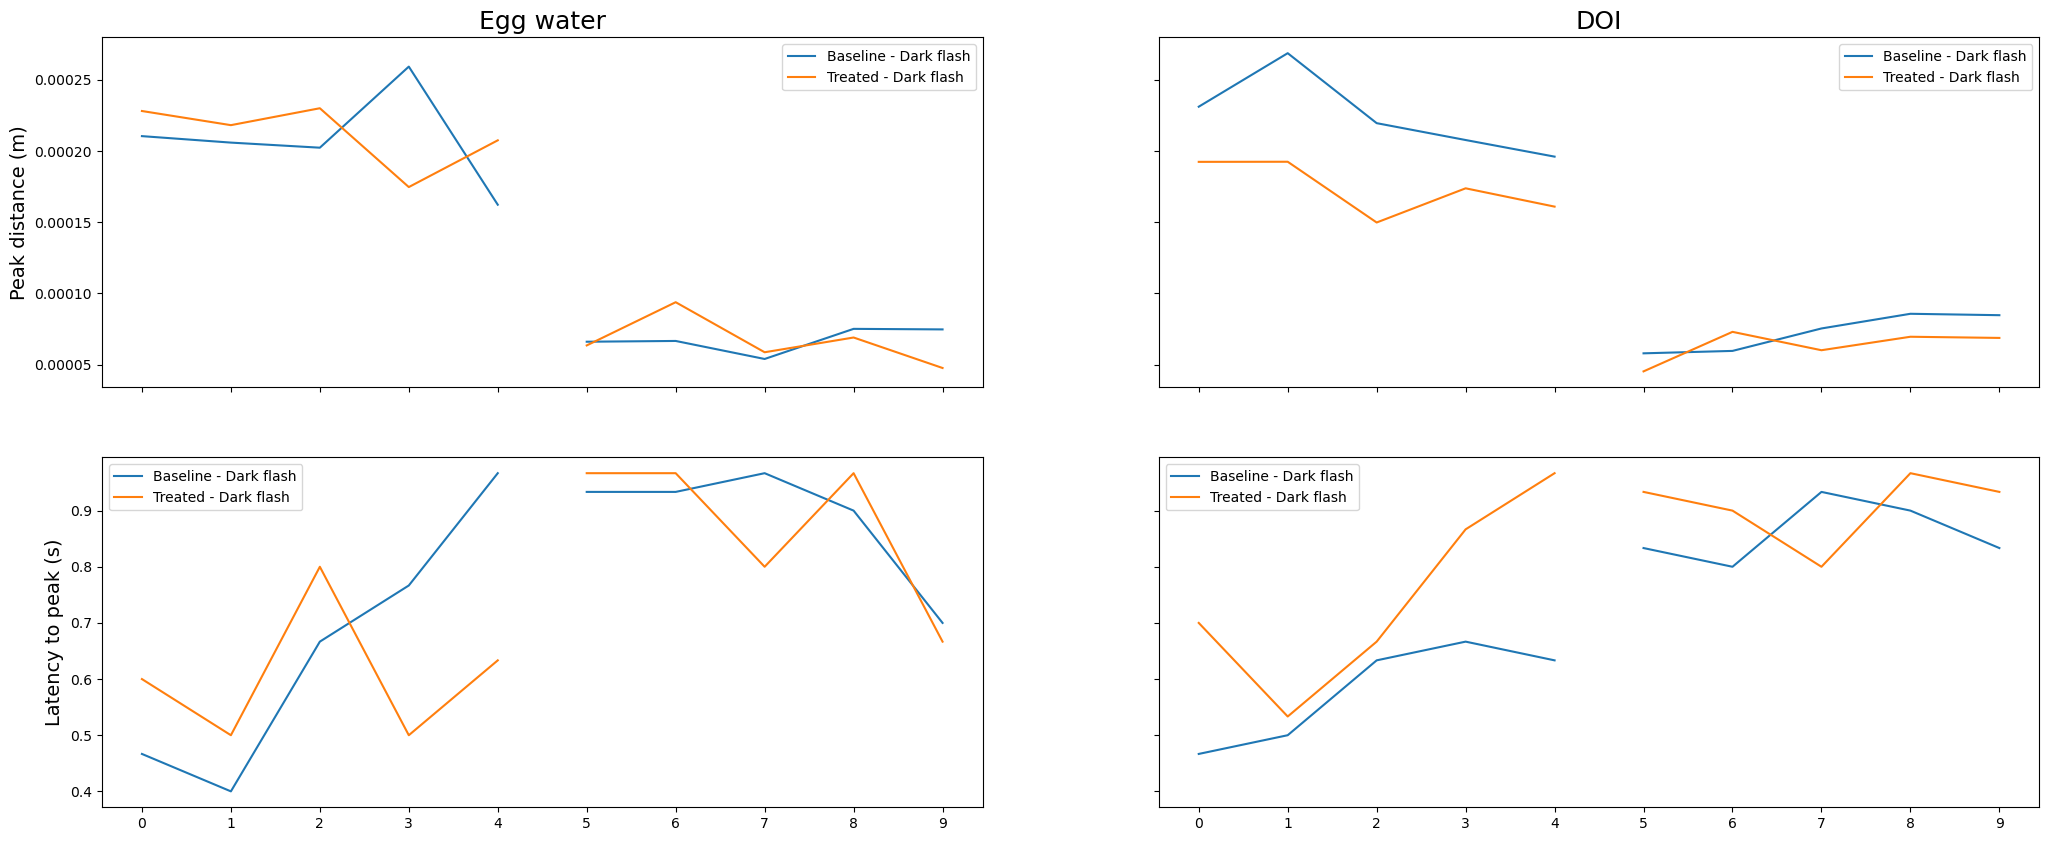

In [476]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row', sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    stim_nums = df[df.stim_name == 'dark_flash'].stim_num.unique()
    
    x = []
    peaks = []
    latencies = []
    
    for num in stim_nums:
        if num == 5:
            peaks.append(np.nan)
            latencies.append(np.nan)
            x.append(np.nan)
            
        trial = df[(df.stim_name == 'dark_flash') & (df.stim_num == num)]
        peak_dist = trial.average_dist.max()
        peak_index = trial.average_dist.idxmax()
        latency = trial.loc[peak_index, 'time'] - trial.iloc[0, 0]
        
        peaks.append(peak_dist)
        latencies.append(latency)
        x.append(num)
    
    col = int(i%2)
    
    axs[0, col].plot(x, peaks, label=f'{labels[i]} - Dark flash')
    axs[0, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[0, col].legend()
    
    axs[1, col].plot(x, latencies, label=f'{labels[i]} - Dark flash')
    axs[1, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[1, col].legend()

    if i in [0, 1]:
        axs[0, col].set_title(titles[i], fontsize=18)
        
    
axs[0, 0].set_ylabel('Peak distance (m)', fontsize=14)
axs[1, 0].set_ylabel('Latency to peak (s)', fontsize=14)
plt.savefig(os.path.join(data_folder, f'darkflash_adaptation_ed.pdf'))

### Light flash

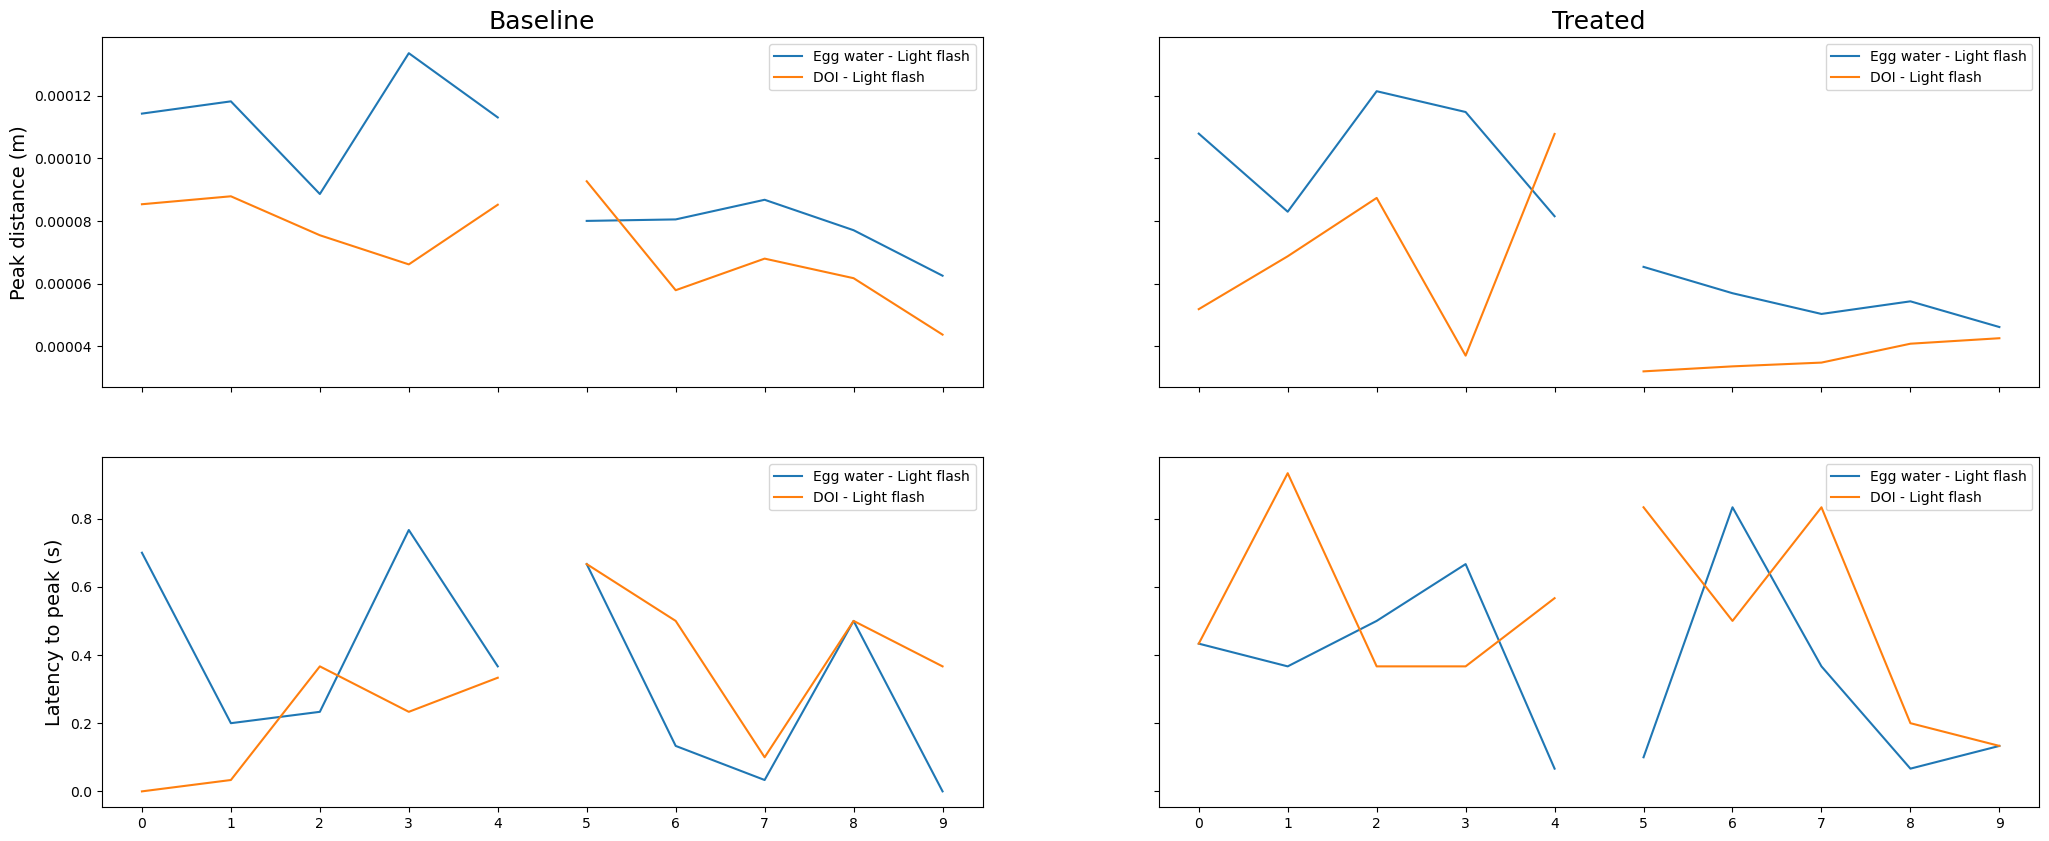

In [477]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row', sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    stim_nums = df[df.stim_name == 'light_flash'].stim_num.unique()
    
    x = []
    peaks = []
    latencies = []
    
    for num in stim_nums:
        if num == 5:
            peaks.append(np.nan)
            latencies.append(np.nan)
            x.append(np.nan)
            
        trial = df[(df.stim_name == 'light_flash') & (df.stim_num == num)]
        peak_dist = trial.average_dist.max()
        peak_index = trial.average_dist.idxmax()
        latency = trial.loc[peak_index, 'time'] - trial.iloc[0, 0]
        
        peaks.append(peak_dist)
        latencies.append(latency)
        x.append(num)
    
    col = int(i/2)
    
    axs[0, col].plot(x, peaks, label=f'{labels[i]} - Light flash')
    axs[0, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[0, col].legend()
    
    axs[1, col].plot(x, latencies, label=f'{labels[i]} - Light flash')
    axs[1, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[1, col].legend()

    if i in [0, 2]:
        axs[0, col].set_title(titles[col], fontsize=18)
        
    
axs[0, 0].set_ylabel('Peak distance (m)', fontsize=14)
axs[1, 0].set_ylabel('Latency to peak (s)', fontsize=14)
plt.savefig(os.path.join(data_folder, f'lightflash_adaptation_bd.pdf'))

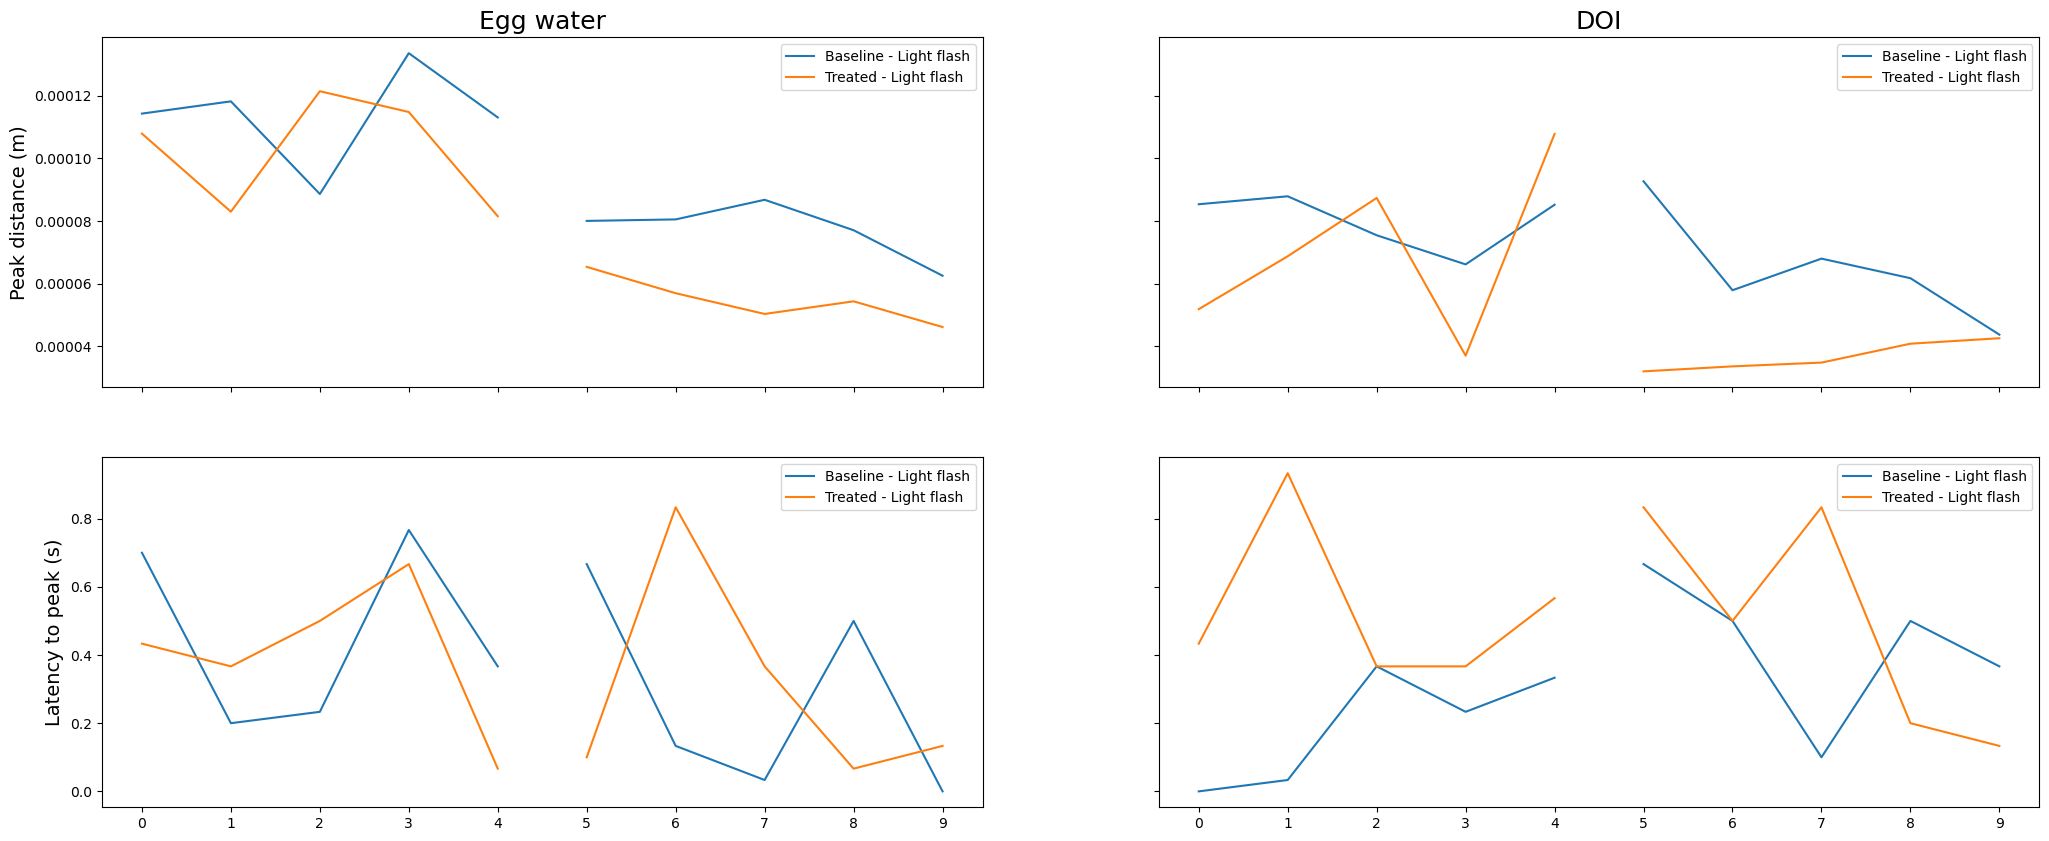

In [479]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row', sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    stim_nums = df[df.stim_name == 'light_flash'].stim_num.unique()
    
    x = []
    peaks = []
    latencies = []
    
    for num in stim_nums:
        if num == 5:
            peaks.append(np.nan)
            latencies.append(np.nan)
            x.append(np.nan)
            
        trial = df[(df.stim_name == 'light_flash') & (df.stim_num == num)]
        peak_dist = trial.average_dist.max()
        peak_index = trial.average_dist.idxmax()
        latency = trial.loc[peak_index, 'time'] - trial.iloc[0, 0]
        
        peaks.append(peak_dist)
        latencies.append(latency)
        x.append(num)
    
    col = int(i%2)
    
    axs[0, col].plot(x, peaks, label=f'{labels[i]} - Light flash')
    axs[0, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[0, col].legend()
    
    axs[1, col].plot(x, latencies, label=f'{labels[i]} - Light flash')
    axs[1, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[1, col].legend()

    if i in [0, 1]:
        axs[0, col].set_title(titles[i], fontsize=18)
        
    
axs[0, 0].set_ylabel('Peak distance (m)', fontsize=14)
axs[1, 0].set_ylabel('Latency to peak (s)', fontsize=14)
plt.savefig(os.path.join(data_folder, f'lightflash_adaptation_ed.pdf'))

### Vibration startle

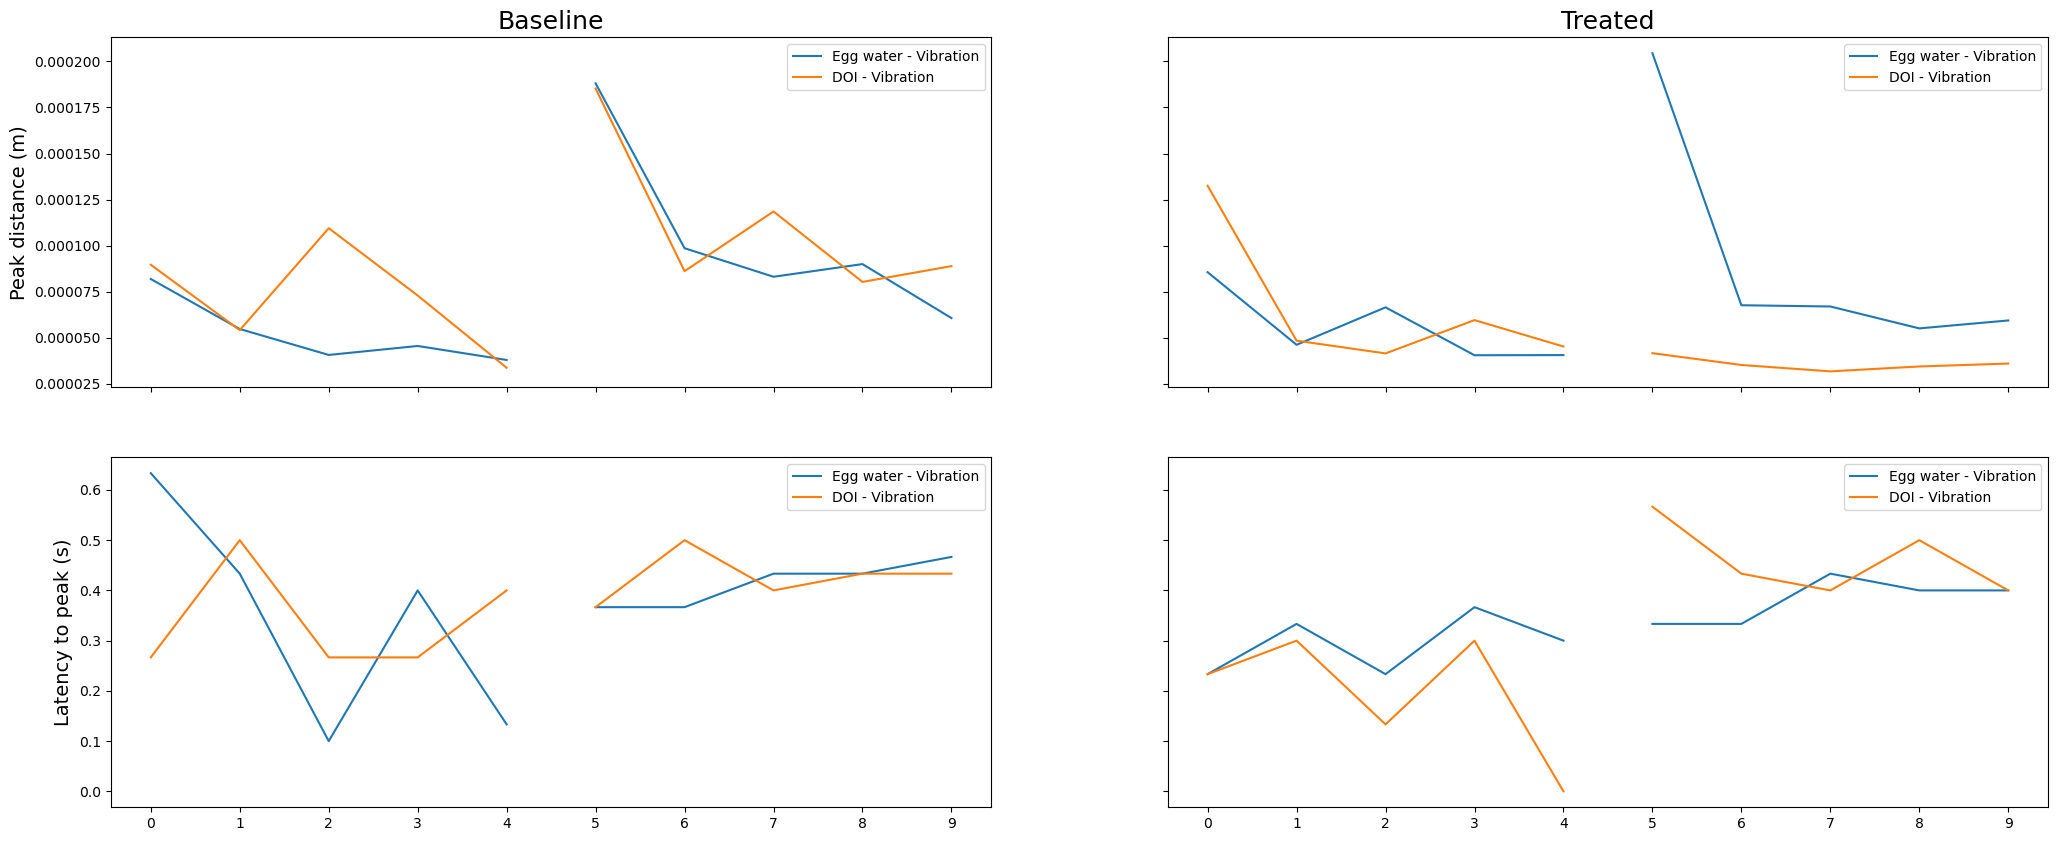

In [481]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row', sharex=True)

titles = ['Baseline', 'Treated']
labels = ['Egg water', 'DOI'] * 2

for i, df in enumerate(dfs):
    stim_nums = df[df.stim_name == 'vibration_startle'].stim_num.unique()
    
    x = []
    peaks = []
    latencies = []
    
    for num in stim_nums:
        if num == 5:
            peaks.append(np.nan)
            latencies.append(np.nan)
            x.append(np.nan)
            
        trial = df[(df.stim_name == 'vibration_startle') & (df.stim_num == num)]
        peak_dist = trial.average_dist.max()
        peak_index = trial.average_dist.idxmax()
        latency = trial.loc[peak_index, 'time'] - trial.iloc[0, 0]
        
        peaks.append(peak_dist)
        latencies.append(latency)
        x.append(num)
    
    col = int(i/2)
    
    axs[0, col].plot(x, peaks, label=f'{labels[i]} - Vibration')
    axs[0, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[0, col].legend()
    
    axs[1, col].plot(x, latencies, label=f'{labels[i]} - Vibration')
    axs[1, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[1, col].legend()

    if i in [0, 2]:
        axs[0, col].set_title(titles[col], fontsize=18)
        
    
axs[0, 0].set_ylabel('Peak distance (m)', fontsize=14)
axs[1, 0].set_ylabel('Latency to peak (s)', fontsize=14)
plt.savefig(os.path.join(data_folder, f'vibration_adaptation_bd.pdf'))

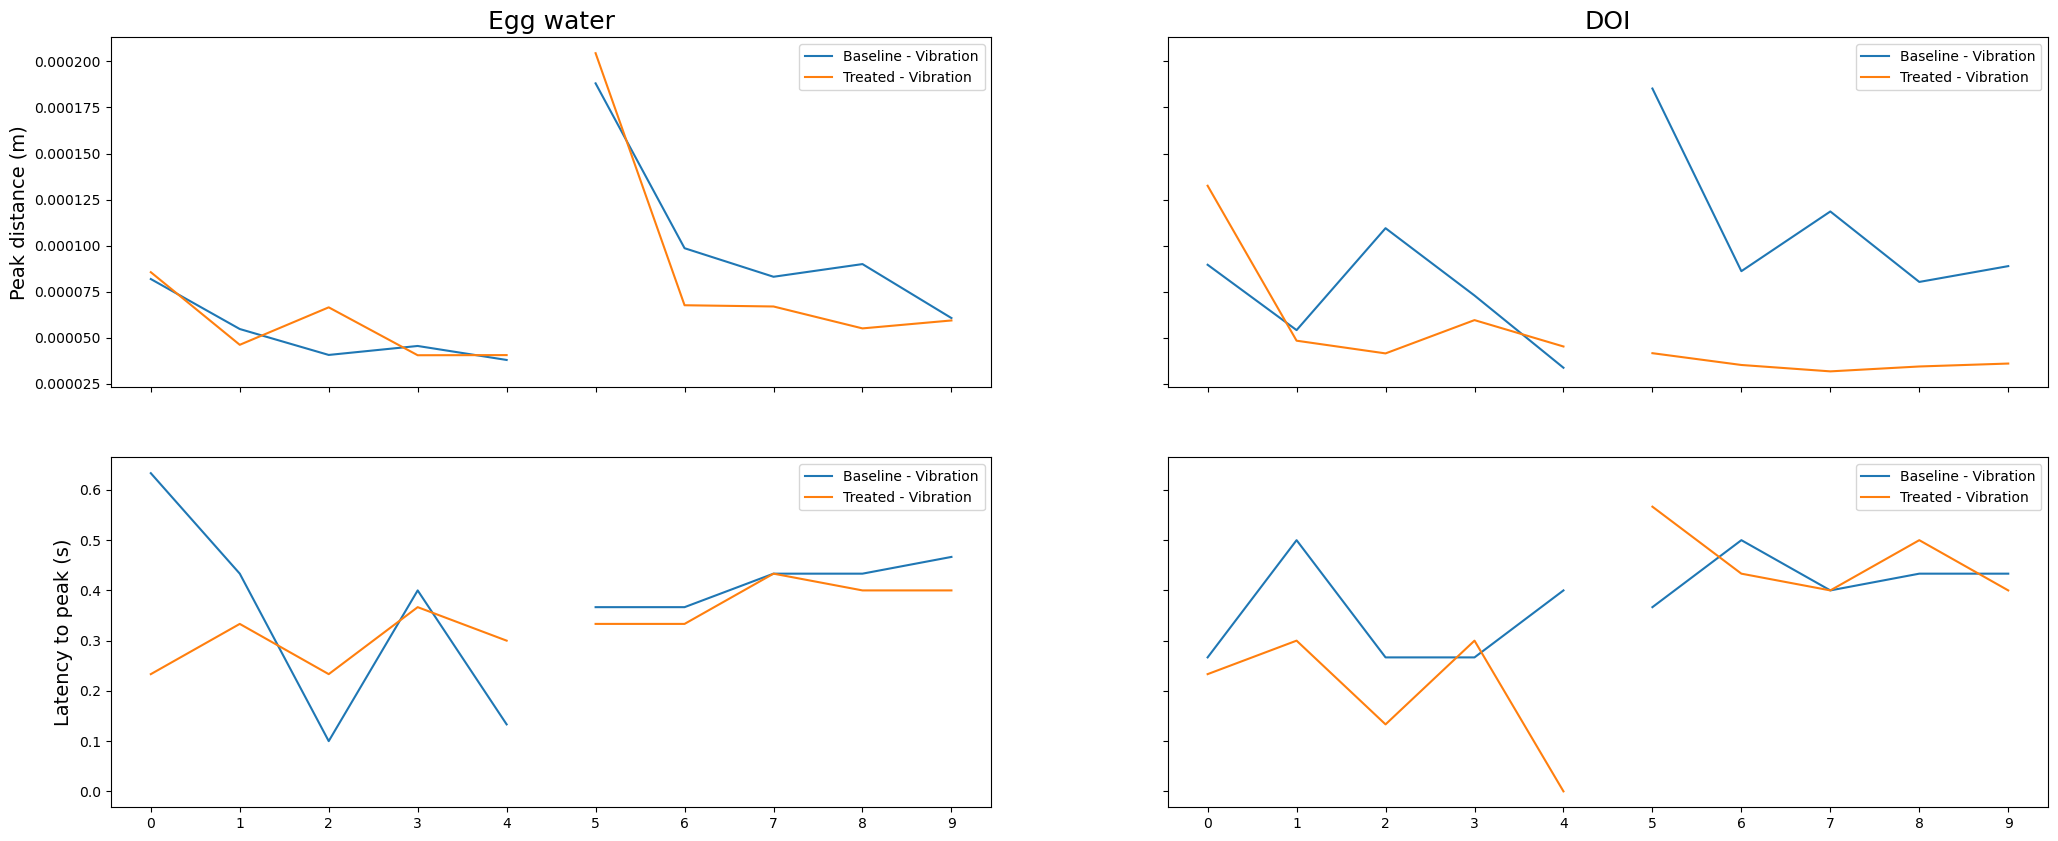

In [599]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey='row', sharex=True)

titles = ['Egg water', 'DOI']
labels = ['Baseline', 'Baseline', 'Treated', 'Treated']

for i, df in enumerate(dfs):
    stim_nums = df[df.stim_name == 'vibration_startle'].stim_num.unique()
    
    x = []
    peaks = []
    latencies = []
    
    for num in stim_nums:
        if num == 5:
            peaks.append(np.nan)
            latencies.append(np.nan)
            x.append(np.nan)
            
        trial = df[(df.stim_name == 'vibration_startle') & (df.stim_num == num)]
        peak_dist = trial.average_dist.max()
        peak_index = trial.average_dist.idxmax()
        latency = trial.loc[peak_index, 'time'] - trial.iloc[0, 0]
        
        peaks.append(peak_dist)
        latencies.append(latency)
        x.append(num)
    
    col = int(i%2)
    
    axs[0, col].plot(x, peaks, label=f'{labels[i]} - Vibration')
    axs[0, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[0, col].legend()
    
    axs[1, col].plot(x, latencies, label=f'{labels[i]} - Vibration')
    axs[1, col].set_xticks(np.arange(min(x), max(x)+1, 1))
    axs[1, col].legend()

    if i in [0, 1]:
        axs[0, col].set_title(titles[i], fontsize=18)
        
    
axs[0, 0].set_ylabel('Peak distance (m)', fontsize=14)
axs[1, 0].set_ylabel('Latency to peak (s)', fontsize=14)
plt.savefig(os.path.join(data_folder, f'vibration_adaptation_ed.pdf'))

## Thigmotaxis

In [600]:
b_thigmo_dfs = []  # list of baseline dataframes
d_thigmo_dfs = []  # list of drugtreated dataframes

cols = ['snout', 'snout', 'snout', 'L_eye', 'L_eye', 'L_eye', 'R_eye', 'R_eye', 'R_eye', 
        'center_y', 'center_x', 'center_likelihood', 'caudal_fin', 'caudal_fin', 'caudal_fin', 'mid_tail', 
        'mid_tail', 'mid_tail', 'between_center_and_mid', 'between_center_and_mid', 
        'between_center_and_mid', 'between_mid_and_caudal', 'between_mid_and_caudal', 
        'between_mid_and_caudal'] * 24
cols = ['time'] + cols

with os.scandir(data_folder) as entries:
    for entry in entries:
        if os.path.isdir(entry.path) and entry.name.startswith('EK'):
            b_csv_path = os.path.join(entry.path, 'baseline', 'Updated_Trimmed_Tracking', 'results', 'tracking_data.csv')
            b_df = pd.read_csv(b_csv_path, header=10).set_axis(cols, axis='columns')
            b_thigmo_dfs.append(b_df)

            d_csv_path = os.path.join(entry.path, 'drugtreated', 'results', 'tracking_data.csv')
            d_df = pd.read_csv(d_csv_path, header=10).set_axis(cols, axis='columns')
            d_thigmo_dfs.append(d_df)

In [567]:
# Split eggwater vs doi baseline

eggwater_b_thigmo_dfs = []
doi_b_thigmo_dfs = []

for i, df in enumerate(b_dfs):
    thigmo_df = df[['time', 'center_y', 'center_x']]
    if i == 0:
        # First dataframe will also include the time column
        eggwater_b_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[:13, 25:37]])
        doi_b_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[0, 13:25, 37:49]])
        
    else:
        eggwater_b_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[1:13, 25:37]])
        doi_b_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[13:25, 37:49]])

In [568]:
# Split eggwater vs doi drugtreated

eggwater_d_thigmo_dfs = []
doi_d_thigmo_dfs = []

for i, df in enumerate(d_dfs):
    thigmo_df = df[['time', 'center_y', 'center_x']]
    if i == 0:
        # First dataframe will also include the time column
        eggwater_d_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[:13, 25:37]])
        doi_d_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[0, 13:25, 37:49]])
        
    else:
        eggwater_d_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[1:13, 25:37]])
        doi_d_thigmo_dfs.append(thigmo_df.iloc[:, np.r_[13:25, 37:49]])

In [569]:
# Concatenate dataframes from different experiment sessions into one 

eggwater_b_df = pd.concat(eggwater_b_thigmo_dfs, axis=1)
doi_b_df = pd.concat(doi_b_thigmo_dfs, axis=1)

eggwater_d_df = pd.concat(eggwater_d_thigmo_dfs, axis=1)
doi_d_df = pd.concat(doi_d_thigmo_dfs, axis=1)

In [570]:
# Add stimuli to main dataframes and save as csv

stim_df = pd.read_csv(os.path.join(data_folder, 'stim_df.csv'), index_col=0)

dfs = {'eggwater_baseline': eggwater_b_df, 
       'doi_baseline': doi_b_df, 
       'eggwater_drugtreated': eggwater_d_df, 
       'doi_drugtreated': doi_d_df}

for i, name in enumerate(dfs):
    df = pd.concat([dfs[name], stim_df], axis=1)
    df.to_csv(os.path.join(data_folder, f'{name}_thigmotaxis.csv'))

### Load the dataframes

In [571]:
eggwater_baseline = pd.read_csv(os.path.join(data_folder, 'eggwater_baseline_thigmotaxis.csv'), index_col=0)
doi_baseline = pd.read_csv(os.path.join(data_folder, 'doi_baseline_thigmotaxis.csv'), index_col=0)
eggwater_drugtreated = pd.read_csv(os.path.join(data_folder, 'eggwater_drugtreated_thigmotaxis.csv'), index_col=0)
doi_drugtreated = pd.read_csv(os.path.join(data_folder, 'doi_drugtreated_thigmotaxis.csv'), index_col=0)

dfs = [eggwater_baseline, doi_baseline, eggwater_drugtreated, doi_drugtreated]

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/1610477304.py:1: DtypeWarning: Columns (147,149) have mixed types. Specify dtype option on import or set low_memory=False.
  eggwater_baseline = pd.read_csv(os.path.join(data_folder, 'eggwater_baseline_thigmotaxis.csv'), index_col=0)
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/1610477304.py:2: DtypeWarning: Columns (147,149) have mixed types. Specify dtype option on import or set low_memory=False.
  doi_baseline = pd.read_csv(os.path.join(data_folder, 'doi_baseline_thigmotaxis.csv'), index_col=0)
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/1610477304.py:3: DtypeWarning: Columns (147,149) have mixed types. Specify dtype option on import or set low_memory=False.
  eggwater_drugtreated = pd.read_csv(os.path.join(data_folder, 'eggwater_drugtreated_thigmotaxis.csv'), index_col=0)
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/1610477304.py:4: DtypeWarning: Columns (14

### Calculate distance from center

In [582]:
for df in dfs:
    df[['dist_from_center']+[f'dist_from_center.{i}' for i in range(1, 72)]] = 0
    
    for i, row in df.iterrows():
        for j in range(72):
            if j == 0:
                df.loc[i, 'dist_from_center'] = np.linalg.norm((row['center_x'], row['center_y']))
            
            else:
                df.loc[i, f'dist_from_center.{j}'] = np.linalg.norm((row[f'center_x.{j}'], row[f'center_y.{j}']))

In [591]:
# Add an 'average_dist_from_center' column that has the average distance from center across fish

cols = [col for col in dfs[0] if col.startswith('dist_from_center')]
df_names = ['eggwater_baseline', 'doi_baseline', 'eggwater_drugtreated', 'doi_drugtreated']

for i, df in enumerate(dfs):
    df['average_dist_from_center'] = df[cols].mean(axis=1)
    df.to_csv(os.path.join(data_folder, f'{df_names[i]}_thigmotaxis.csv'))

### Whole experiment thigmotaxis

In [592]:
# Adds a binned_time column which is the time that each row belongs to

time_bin = 1.0 # in seconds

for df in dfs:
    df['binned_time'] = 0

    for i, row in df.iterrows():
        if df.loc[i, 'time'] < time_bin:
            df.loc[i, 'binned_time'] = time_bin
        else:
            time_bin += 1
            df.loc[i, 'binned_time'] = time_bin
            
    time_bin = 1.0

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2534149524.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0, 0].plot(eggwater_baseline.groupby(['binned_time']).mean()['average_dist_from_center'])
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2534149524.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0, 1].plot(doi_baseline.groupby(['binned_time']).mean()['average_dist_from_center'])
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/2534149524.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a

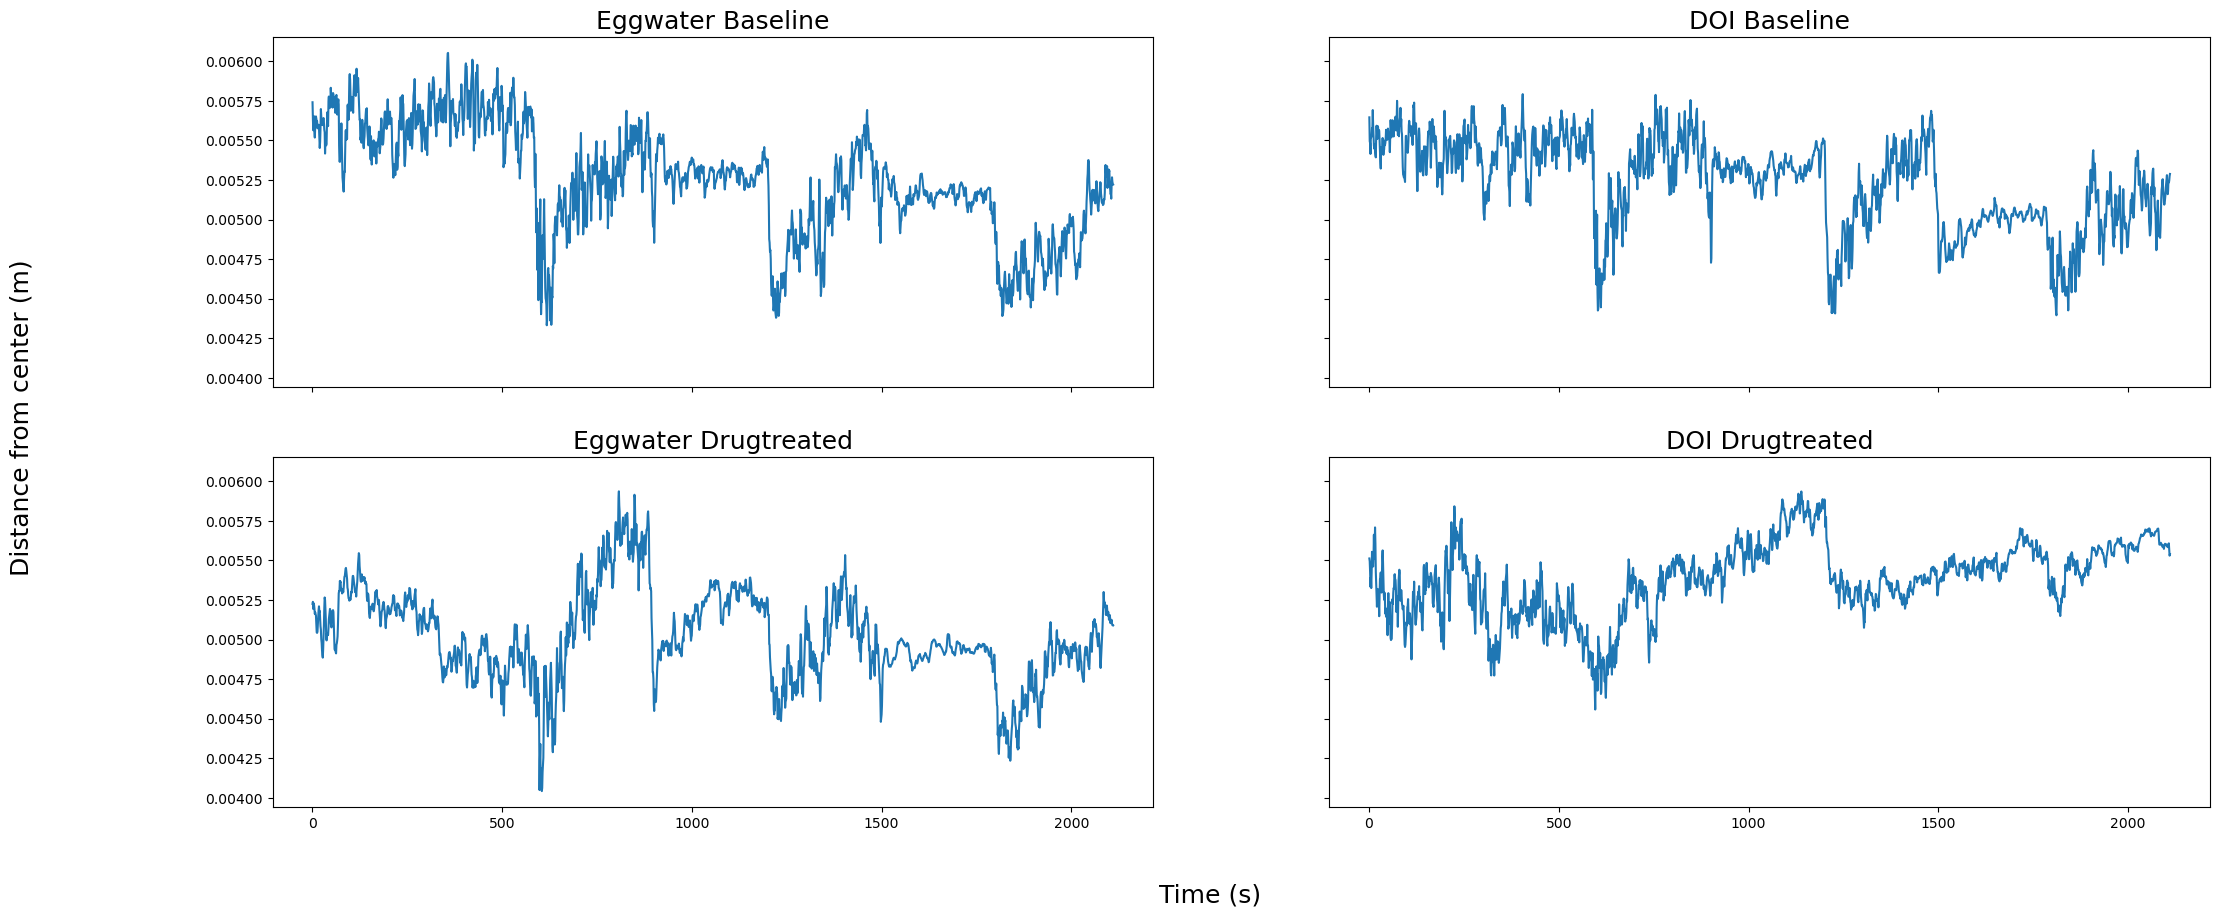

In [594]:
fig, axs = plt.subplots(2, 2, figsize=(25, 10), sharey=True, sharex=True)

axs[0, 0].plot(eggwater_baseline.groupby(['binned_time']).mean()['average_dist_from_center'])
axs[0, 0].set_title('Eggwater Baseline', fontsize=18)

axs[0, 1].plot(doi_baseline.groupby(['binned_time']).mean()['average_dist_from_center'])
axs[0, 1].set_title('DOI Baseline', fontsize=18)

axs[1, 0].plot(eggwater_drugtreated.groupby(['binned_time']).mean()['average_dist_from_center'])
axs[1, 0].set_title('Eggwater Drugtreated', fontsize=18)

axs[1, 1].plot(doi_drugtreated.groupby(['binned_time']).mean()['average_dist_from_center'])
axs[1, 1].set_title('DOI Drugtreated', fontsize=18)

fig.supxlabel('Time (s)', fontsize=18)
fig.supylabel('Distance from center (m)', fontsize=18)

plt.savefig(os.path.join(data_folder, f'distance_from_center_all_binned{time_bin}s.pdf'))

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/3284836237.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(eggwater_baseline.groupby(['binned_time']).mean()['average_dist_from_center'], label='Egg water')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/3284836237.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(doi_baseline.groupby(['binned_time']).mean()['average_dist_from_center'], label='DOI')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/3284836237.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupB

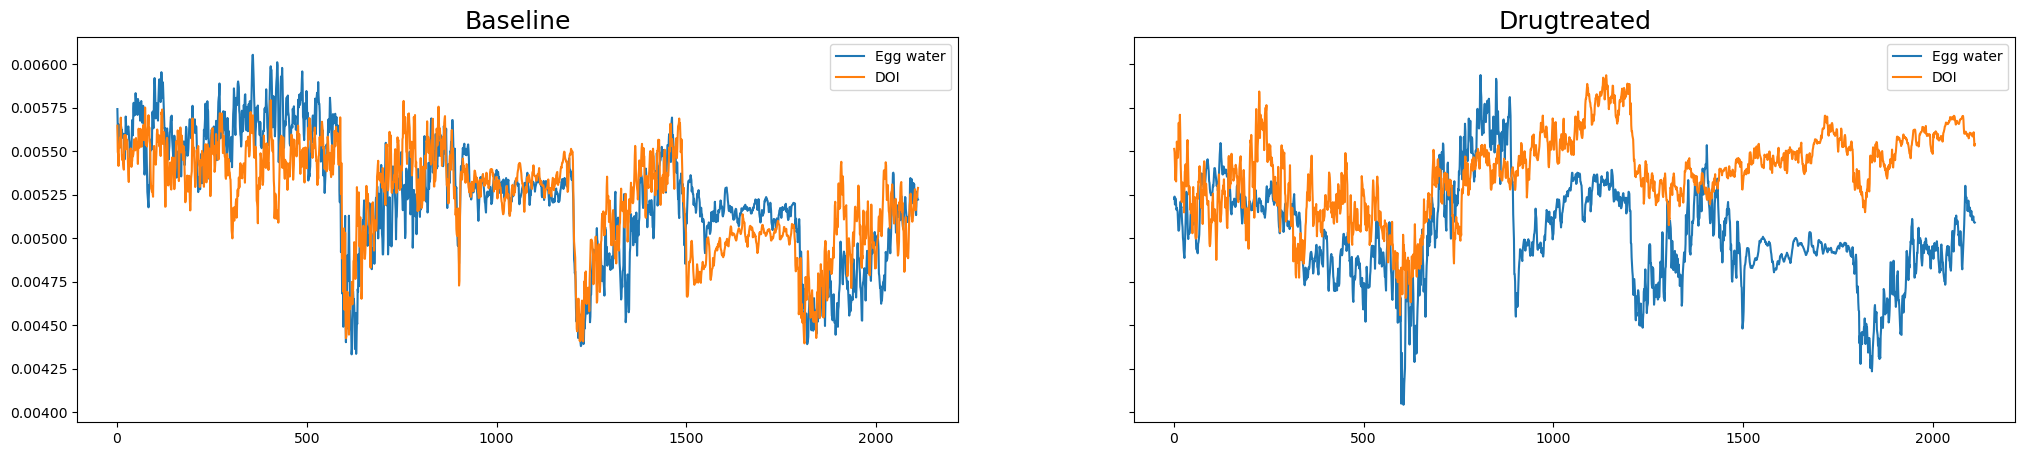

In [595]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

axs[0].plot(eggwater_baseline.groupby(['binned_time']).mean()['average_dist_from_center'], label='Egg water')
axs[0].plot(doi_baseline.groupby(['binned_time']).mean()['average_dist_from_center'], label='DOI')
axs[0].set_title('Baseline', fontsize=18)
axs[0].legend()

axs[1].plot(eggwater_drugtreated.groupby(['binned_time']).mean()['average_dist_from_center'], label='Egg water')
axs[1].plot(doi_drugtreated.groupby(['binned_time']).mean()['average_dist_from_center'], label='DOI')
axs[1].set_title('Drugtreated', fontsize=18)
axs[1].legend()

plt.savefig(os.path.join(data_folder, f'distance_from_center_bd_binned{time_bin}s.pdf'))

/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/3553436785.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(eggwater_baseline.groupby(['binned_time']).mean()['average_dist_from_center'], label='Baseline')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/3553436785.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  axs[0].plot(eggwater_drugtreated.groupby(['binned_time']).mean()['average_dist_from_center'], label='Treated')
/var/folders/48/8y2gqcvx5q5575kwkzngl6qw0000gn/T/ipykernel_65625/3553436785.py:8: FutureWarning: The default value of numeric_only in Data

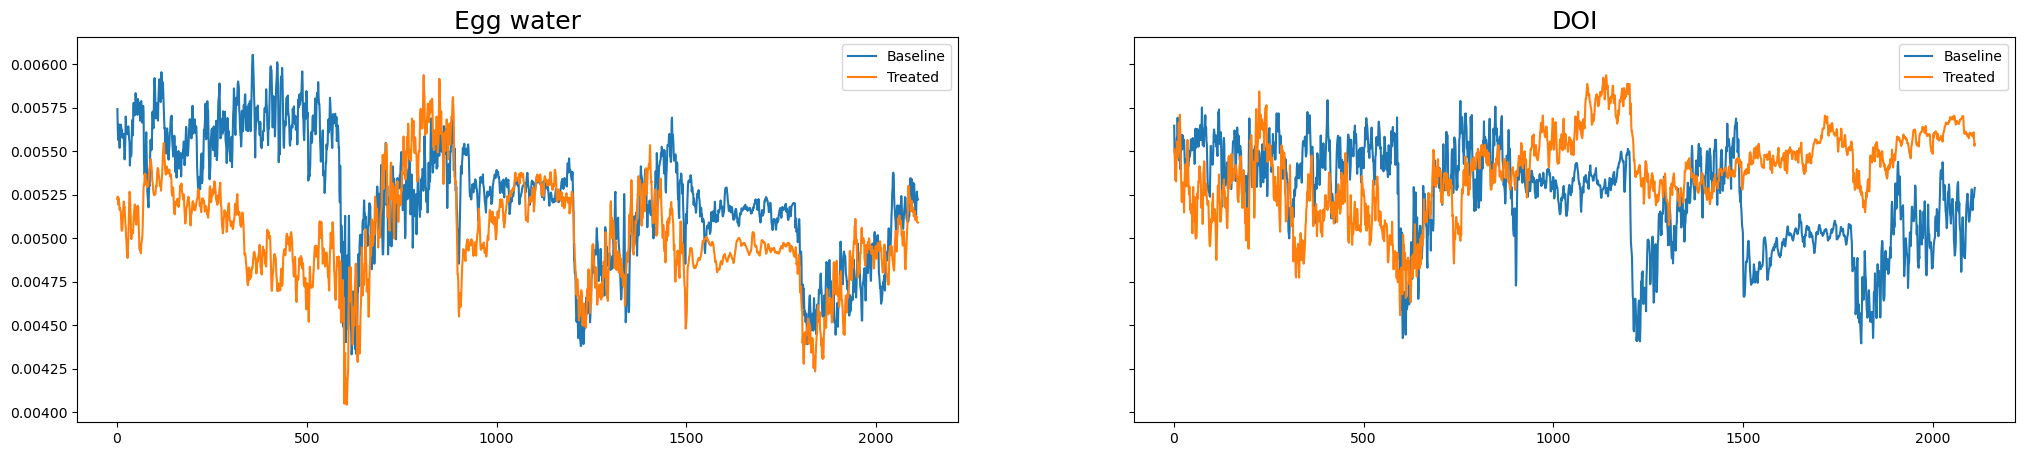

In [596]:
fig, axs = plt.subplots(1, 2, figsize=(25, 5), sharey=True, sharex=True)

axs[0].plot(eggwater_baseline.groupby(['binned_time']).mean()['average_dist_from_center'], label='Baseline')
axs[0].plot(eggwater_drugtreated.groupby(['binned_time']).mean()['average_dist_from_center'], label='Treated')
axs[0].set_title('Egg water', fontsize=18)
axs[0].legend()

axs[1].plot(doi_baseline.groupby(['binned_time']).mean()['average_dist_from_center'], label='Baseline')
axs[1].plot(doi_drugtreated.groupby(['binned_time']).mean()['average_dist_from_center'], label='Treated')
axs[1].set_title('DOI', fontsize=18)
axs[1].legend()

plt.savefig(os.path.join(data_folder, f'distance_from_center_ed_binned{time_bin}s.pdf'))

### Dark flash

## Average peak startle response

### Dark flash